# NOTEBOOK FOR THE ANALYSIS OF SINGLE-CELL RNA-SEQUENCING DATA FROM PATIENT-DERIVED XENOGRAFTS

In [1]:
# load required modules
import numpy as np
import pandas as pd
import scanpy as sc
import bbknn
import scrublet as scr
import pandas as pd
from matplotlib import rcParams
import session_info
from SCCAF import SCCAF_assessment, plot_roc, SCCAF_optimize_all
import mnnpy
import scanpy.external as sce
import harmonypy

/home/przybilm/.local/lib/python3.7/site-packages/mnnpy/utils.py:14: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "l2_norm" failed type inference due to: No implementation of function Function(<function norm at 0x2b88230a1bf8>) found for signature:
 
 >>> norm(x=array(float32, 2d, A), axis=Literal[int](1))
 
There are 2 candidate implementations:
  - Of which 2 did not match due to:
  Overload in function 'norm_impl': File: numba/np/linalg.py: Line 2351.
    With argument(s): '(x=array(float32, 2d, A), axis=int64)':
   Rejected as the implementation raised a specific error:
     TypeError: norm_impl() got an unexpected keyword argument 'x'
  raised from /home/przybilm/.local/lib/python3.7/site-packages/numba/core/typing/templates.py:775

During: resolving callee type: Function(<function norm at 0x2b88230a1bf8>)
During: typing of call at /home/przybilm/.local/lib/python3.7/site-packages/mnnpy/utils.py (16)


File "../../.local/lib/p

In [2]:
session_info.show()

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white',  dpi_save=600)

In [4]:
results_file = '/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/revision/scrna_analysis/PDX_merge_scanpy.h5ad'  # the file that will store the analysis results

## READ IN THE DATA FOR LFSMBP-PDX AND PERFORM DOUBLET REMOVAL WITH SCRUBLET

In [5]:
adata_stp = sc.read_10x_mtx(
    '/omics/groups/OE0540/internal/projects/chromothripsis_medulloblastoma/data/10XRNA5P/STP/STP-PDX/outs/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

adata_stp.var_names_make_unique()
adata_stp

# make some metadata
adata_stp.obs['sample'] = "STP"
adata_stp.obs['technology'] = "PDX"
adata_stp.obs['patient'] = "ST"

... reading from cache file cache/omics-groups-OE0540-internal-projects-chromothripsis_medulloblastoma-data-10XRNA5P-STP-STP-PDX-outs-filtered_feature_bc_matrix-matrix.h5ad


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [6]:
adata_stp

AnnData object with n_obs × n_vars = 4724 × 32738
    obs: 'sample', 'technology', 'patient'
    var: 'gene_ids', 'feature_types'

In [7]:
# remove the mouse cells from the sample
stp_mouse_cells = pd.read_csv("/omics/groups/OE0540/internal/projects/chromothripsis_medulloblastoma/data/10XRNA5P/STP/mm10_and_hg19/sample3.mapping.counts.txt", sep = '\t')
stp_mouse_cells

cell  count.hg19  count.mm10  total.count       ratio
0     AAACCTGCACGTTGGC-1         750           9          759   83.333333
1     AAACCTGCATCATCCC-1        1742           5         1747  348.400000
2     AAACCTGGTGCACTTA-1        2126           3         2129  708.666667
3     AAACCTGTCAATACCG-1        2367           4         2371  591.750000
4     AAACCTGTCGCGTAGC-1        2518           3         2521  839.333333
...                  ...         ...         ...          ...         ...
4781  TTTGTCATCACCATAG-1        1433           2         1435  716.500000
4782  TTTGTCATCACCCGAG-1        2236           4         2240  559.000000
4783  TTTGTCATCAGAGACG-1        2098           4         2102  524.500000
4784  TTTGTCATCCTGTAGA-1        2377           7         2384  339.571429
4785  TTTGTCATCTTAGCCC-1        1645           5         1650  329.000000

[4786 rows x 5 columns]

In [8]:
stp_mouse_cells = stp_mouse_cells[stp_mouse_cells['ratio'] > 1]
stp_mouse_cells

cell  count.hg19  count.mm10  total.count       ratio
0     AAACCTGCACGTTGGC-1         750           9          759   83.333333
1     AAACCTGCATCATCCC-1        1742           5         1747  348.400000
2     AAACCTGGTGCACTTA-1        2126           3         2129  708.666667
3     AAACCTGTCAATACCG-1        2367           4         2371  591.750000
4     AAACCTGTCGCGTAGC-1        2518           3         2521  839.333333
...                  ...         ...         ...          ...         ...
4781  TTTGTCATCACCATAG-1        1433           2         1435  716.500000
4782  TTTGTCATCACCCGAG-1        2236           4         2240  559.000000
4783  TTTGTCATCAGAGACG-1        2098           4         2102  524.500000
4784  TTTGTCATCCTGTAGA-1        2377           7         2384  339.571429
4785  TTTGTCATCTTAGCCC-1        1645           5         1650  329.000000

[4408 rows x 5 columns]

In [9]:
stp_mouse_cells_barcodes = stp_mouse_cells['cell']
stp_mouse_cells_barcodes 

0       AAACCTGCACGTTGGC-1
1       AAACCTGCATCATCCC-1
2       AAACCTGGTGCACTTA-1
3       AAACCTGTCAATACCG-1
4       AAACCTGTCGCGTAGC-1
               ...        
4781    TTTGTCATCACCATAG-1
4782    TTTGTCATCACCCGAG-1
4783    TTTGTCATCAGAGACG-1
4784    TTTGTCATCCTGTAGA-1
4785    TTTGTCATCTTAGCCC-1
Name: cell, Length: 4408, dtype: object

In [10]:
adata_stp = adata_stp[adata_stp.obs_names.isin(stp_mouse_cells_barcodes),:]

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [11]:
adata_stp

View of AnnData object with n_obs × n_vars = 4376 × 32738
    obs: 'sample', 'technology', 'patient'
    var: 'gene_ids', 'feature_types'

In [12]:
scrub_stp = scr.Scrublet(
        counts_matrix=adata_stp.X,
        expected_doublet_rate=0.1,  # Default is 0.1
        random_state=0)

In [13]:
doublet_scores, predicted_doublets = scrub_stp.scrub_doublets(min_counts=2, 
                                                          min_cells=3, 
                                                          min_gene_variability_pctl=85, 
                                                          n_prin_comps=30)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.50
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 0.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 34.4%
Elapsed time: 4.9 seconds


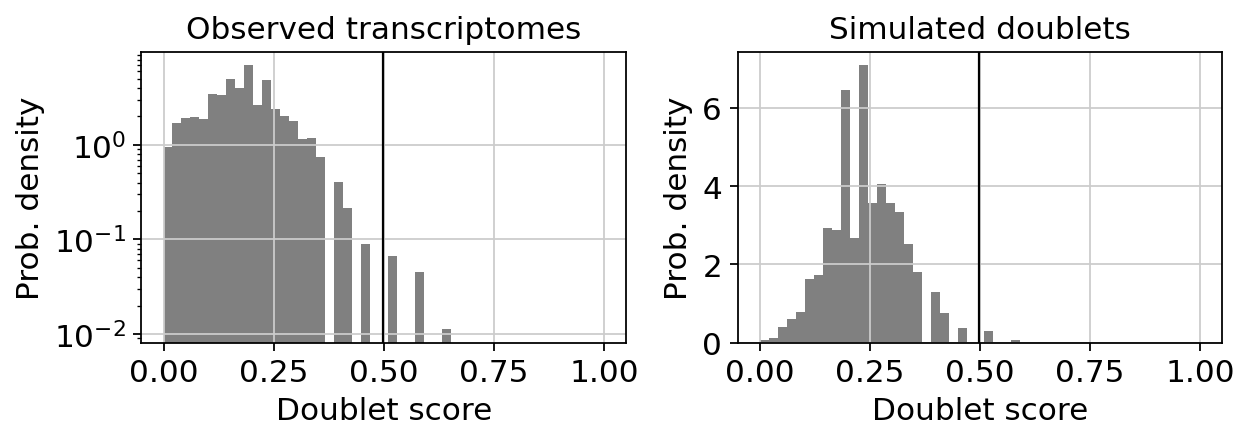

In [14]:
scrub_stp.plot_histogram();

In [15]:
adata_stp.obs['scrublet__predicted_multiplet'] = scrub_stp.predicted_doublets_
adata_stp.obs['scrublet__multiplet_scores'] = scrub_stp.doublet_scores_obs_
adata_stp.obs['scrublet__multiplet_zscores'] = scrub_stp.z_scores_

Trying to set attribute `.obs` of view, copying.


In [16]:
adata_stp.obs

sample technology patient  scrublet__predicted_multiplet  \
AAACCTGCACGTTGGC-1    STP        PDX      ST                          False   
AAACCTGCATCATCCC-1    STP        PDX      ST                          False   
AAACCTGGTGCACTTA-1    STP        PDX      ST                          False   
AAACCTGTCAATACCG-1    STP        PDX      ST                          False   
AAACCTGTCGCGTAGC-1    STP        PDX      ST                          False   
...                   ...        ...     ...                            ...   
TTTGTCATCACCATAG-1    STP        PDX      ST                          False   
TTTGTCATCACCCGAG-1    STP        PDX      ST                          False   
TTTGTCATCAGAGACG-1    STP        PDX      ST                          False   
TTTGTCATCCTGTAGA-1    STP        PDX      ST                          False   
TTTGTCATCTTAGCCC-1    STP        PDX      ST                          False   

                    scrublet__multiplet_scores  scrublet__multiplet_zscores  
AAACCTGCACGTTGGC-1                    0.060000                   -26.020484  
AAACCTGCATCATCCC-1                    0.126516                   -10.700572  
AAACCTGGTGCACTTA-1                    0.227882                    -4.367256  
AAACCTGTCAATACCG-1                    0.273292                    -3.049375  
AAACCTGTCGCGTAGC-1                    0.227882                    -4.367256  
...                                        ...                          ...  
TTTGTCATCACCATAG-1                    0.312500                    -2.217844  
TTTGTCATCACCCGAG-1                    0.151277                    -8.376908  
TTTGTCATCAGAGACG-1                    0.174672                    -6.781102  
TTTGTCATCCTGTAGA-1                    0.227882                    -4.367256  
TTTGTCATCTTAGCCC-1                    0.126516                   -10.700572  

[4376 rows x 6 columns]

In [17]:
# count the number of predicted multiplets
adata_stp.obs['scrublet__predicted_multiplet'].value_counts() 

False    4365
True       11
Name: scrublet__predicted_multiplet, dtype: int64

In [18]:
# remove predicted doublets
adata_stp = adata_stp[adata_stp.obs['scrublet__predicted_multiplet'] == False]

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [19]:
adata_stp.obs

sample technology patient  scrublet__predicted_multiplet  \
AAACCTGCACGTTGGC-1    STP        PDX      ST                          False   
AAACCTGCATCATCCC-1    STP        PDX      ST                          False   
AAACCTGGTGCACTTA-1    STP        PDX      ST                          False   
AAACCTGTCAATACCG-1    STP        PDX      ST                          False   
AAACCTGTCGCGTAGC-1    STP        PDX      ST                          False   
...                   ...        ...     ...                            ...   
TTTGTCATCACCATAG-1    STP        PDX      ST                          False   
TTTGTCATCACCCGAG-1    STP        PDX      ST                          False   
TTTGTCATCAGAGACG-1    STP        PDX      ST                          False   
TTTGTCATCCTGTAGA-1    STP        PDX      ST                          False   
TTTGTCATCTTAGCCC-1    STP        PDX      ST                          False   

                    scrublet__multiplet_scores  scrublet__multiplet_zscores  
AAACCTGCACGTTGGC-1                    0.060000                   -26.020484  
AAACCTGCATCATCCC-1                    0.126516                   -10.700572  
AAACCTGGTGCACTTA-1                    0.227882                    -4.367256  
AAACCTGTCAATACCG-1                    0.273292                    -3.049375  
AAACCTGTCGCGTAGC-1                    0.227882                    -4.367256  
...                                        ...                          ...  
TTTGTCATCACCATAG-1                    0.312500                    -2.217844  
TTTGTCATCACCCGAG-1                    0.151277                    -8.376908  
TTTGTCATCAGAGACG-1                    0.174672                    -6.781102  
TTTGTCATCCTGTAGA-1                    0.227882                    -4.367256  
TTTGTCATCTTAGCCC-1                    0.126516                   -10.700572  

[4365 rows x 6 columns]

## READ IN THE DATA FOR LFSMB1R-PDX AND PERFORM DOUBLET REMOVAL WITH SCRUBLET

In [20]:
adata_st1r = sc.read_10x_mtx(
    '/omics/groups/OE0540/internal/projects/chromothripsis_medulloblastoma/data/10XRNA5P/ST1R/ST1R-PDX/outs/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

adata_st1r.var_names_make_unique()
adata_st1r

# make some metadata
adata_st1r.obs['sample'] = "ST1R"
adata_st1r.obs['technology'] = "PDX"
adata_st1r.obs['patient'] = "ST"

... reading from cache file cache/omics-groups-OE0540-internal-projects-chromothripsis_medulloblastoma-data-10XRNA5P-ST1R-ST1R-PDX-outs-filtered_feature_bc_matrix-matrix.h5ad


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [21]:
adata_st1r

AnnData object with n_obs × n_vars = 2207 × 32738
    obs: 'sample', 'technology', 'patient'
    var: 'gene_ids', 'feature_types'

In [22]:
# remove mouse cells
st1r_mouse_cells = pd.read_csv("/omics/groups/OE0540/internal/projects/chromothripsis_medulloblastoma/data/10XRNA5P/ST1R/mm10_and_hg19/sample4.mapping.counts.txt", sep = '\t')
st1r_mouse_cells

cell  count.hg19  count.mm10  total.count        ratio
0     AAACCTGAGTACATGA-1        3240           6         3246   540.000000
1     AAACCTGCAAGCCCAC-1        3089           2         3091  1544.500000
2     AAACCTGCAGCCAATT-1        5127          10         5137   512.700000
3     AAACGGGAGCGAGAAA-1        3671           9         3680   407.888889
4     AAACGGGCAGATAATG-1         587           1          588   587.000000
...                  ...         ...         ...          ...          ...
2224  TTTGGTTGTTACGTCA-1        1533           6         1539   255.500000
2225  TTTGGTTTCAAACAAG-1        8978           7         8985  1282.571429
2226  TTTGTCAAGTCCCACG-1        1489           3         1492   496.333333
2227  TTTGTCACAATGCCAT-1        3210           5         3215   642.000000
2228  TTTGTCACATAACCTG-1        2689           7         2696   384.142857

[2229 rows x 5 columns]

In [23]:
st1r_mouse_cells = st1r_mouse_cells[st1r_mouse_cells['ratio'] > 1]
st1r_mouse_cells

cell  count.hg19  count.mm10  total.count        ratio
0     AAACCTGAGTACATGA-1        3240           6         3246   540.000000
1     AAACCTGCAAGCCCAC-1        3089           2         3091  1544.500000
2     AAACCTGCAGCCAATT-1        5127          10         5137   512.700000
3     AAACGGGAGCGAGAAA-1        3671           9         3680   407.888889
4     AAACGGGCAGATAATG-1         587           1          588   587.000000
...                  ...         ...         ...          ...          ...
2224  TTTGGTTGTTACGTCA-1        1533           6         1539   255.500000
2225  TTTGGTTTCAAACAAG-1        8978           7         8985  1282.571429
2226  TTTGTCAAGTCCCACG-1        1489           3         1492   496.333333
2227  TTTGTCACAATGCCAT-1        3210           5         3215   642.000000
2228  TTTGTCACATAACCTG-1        2689           7         2696   384.142857

[2077 rows x 5 columns]

In [24]:
st1r_mouse_cells_barcodes = st1r_mouse_cells['cell']
st1r_mouse_cells_barcodes 

0       AAACCTGAGTACATGA-1
1       AAACCTGCAAGCCCAC-1
2       AAACCTGCAGCCAATT-1
3       AAACGGGAGCGAGAAA-1
4       AAACGGGCAGATAATG-1
               ...        
2224    TTTGGTTGTTACGTCA-1
2225    TTTGGTTTCAAACAAG-1
2226    TTTGTCAAGTCCCACG-1
2227    TTTGTCACAATGCCAT-1
2228    TTTGTCACATAACCTG-1
Name: cell, Length: 2077, dtype: object

In [25]:
adata_st1r = adata_st1r[adata_st1r.obs_names.isin(st1r_mouse_cells_barcodes),:]

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [26]:
adata_st1r

View of AnnData object with n_obs × n_vars = 2056 × 32738
    obs: 'sample', 'technology', 'patient'
    var: 'gene_ids', 'feature_types'

In [27]:
scrub_st1r = scr.Scrublet(
        counts_matrix=adata_st1r.X,
        expected_doublet_rate=0.1,  # Default is 0.1
        random_state=0)

In [28]:
doublet_scores, predicted_doublets = scrub_st1r.scrub_doublets(min_counts=2, 
                                                          min_cells=3, 
                                                          min_gene_variability_pctl=85, 
                                                          n_prin_comps=30)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.53
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 0.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 30.3%
Elapsed time: 1.8 seconds


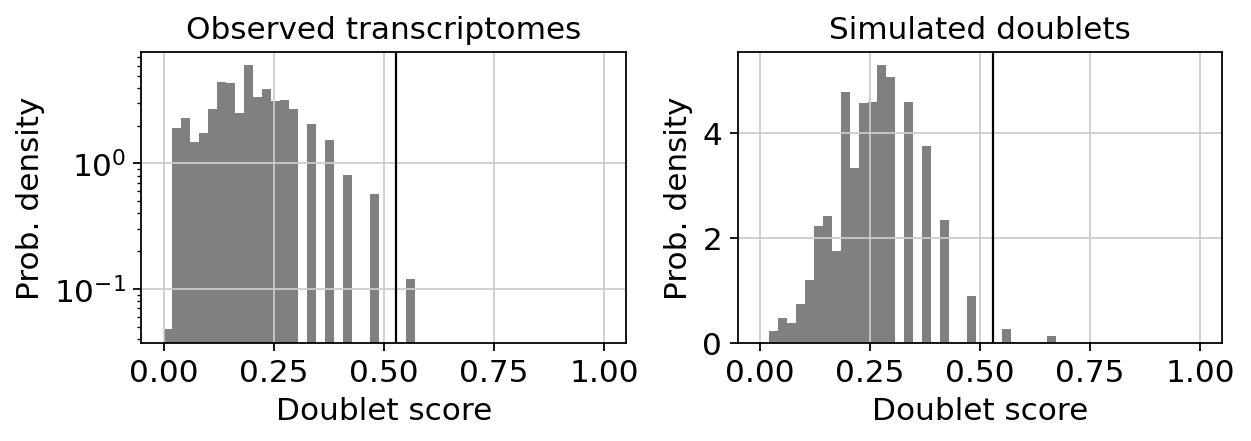

In [29]:
scrub_st1r.plot_histogram();

In [30]:
adata_st1r.obs['scrublet__predicted_multiplet'] = scrub_st1r.predicted_doublets_
adata_st1r.obs['scrublet__multiplet_scores'] = scrub_st1r.doublet_scores_obs_
adata_st1r.obs['scrublet__multiplet_zscores'] = scrub_st1r.z_scores_

Trying to set attribute `.obs` of view, copying.


In [31]:
adata_st1r.obs

sample technology patient  scrublet__predicted_multiplet  \
AAACCTGAGTACATGA-1   ST1R        PDX      ST                          False   
AAACCTGCAAGCCCAC-1   ST1R        PDX      ST                          False   
AAACCTGCAGCCAATT-1   ST1R        PDX      ST                          False   
AAACGGGAGCGAGAAA-1   ST1R        PDX      ST                          False   
AAACGGGCAGATAATG-1   ST1R        PDX      ST                          False   
...                   ...        ...     ...                            ...   
TTTGGTTGTTACGTCA-1   ST1R        PDX      ST                          False   
TTTGGTTTCAAACAAG-1   ST1R        PDX      ST                          False   
TTTGTCAAGTCCCACG-1   ST1R        PDX      ST                          False   
TTTGTCACAATGCCAT-1   ST1R        PDX      ST                          False   
TTTGTCACATAACCTG-1   ST1R        PDX      ST                          False   

                    scrublet__multiplet_scores  scrublet__multiplet_zscores  
AAACCTGAGTACATGA-1                    0.423077                    -0.845907  
AAACCTGCAAGCCCAC-1                    0.171779                    -6.885406  
AAACCTGCAGCCAATT-1                    0.253112                    -3.597584  
AAACGGGAGCGAGAAA-1                    0.198630                    -5.497660  
AAACGGGCAGATAATG-1                    0.032967                   -47.244557  
...                                        ...                          ...  
TTTGGTTGTTACGTCA-1                    0.160350                    -7.618291  
TTTGGTTTCAAACAAG-1                    0.150000                    -8.378534  
TTTGTCAAGTCCCACG-1                    0.103896                   -13.584483  
TTTGTCACAATGCCAT-1                    0.160350                    -7.618291  
TTTGTCACATAACCTG-1                    0.160350                    -7.618291  

[2056 rows x 6 columns]

In [32]:
# count the number of predicted multiplets
adata_st1r.obs['scrublet__predicted_multiplet'].value_counts() 

False    2051
True        5
Name: scrublet__predicted_multiplet, dtype: int64

In [33]:
# remove predicted doublets
adata_st1r = adata_st1r[adata_st1r.obs['scrublet__predicted_multiplet'] == False]

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [34]:
adata_st1r.obs

sample technology patient  scrublet__predicted_multiplet  \
AAACCTGAGTACATGA-1   ST1R        PDX      ST                          False   
AAACCTGCAAGCCCAC-1   ST1R        PDX      ST                          False   
AAACCTGCAGCCAATT-1   ST1R        PDX      ST                          False   
AAACGGGAGCGAGAAA-1   ST1R        PDX      ST                          False   
AAACGGGCAGATAATG-1   ST1R        PDX      ST                          False   
...                   ...        ...     ...                            ...   
TTTGGTTGTTACGTCA-1   ST1R        PDX      ST                          False   
TTTGGTTTCAAACAAG-1   ST1R        PDX      ST                          False   
TTTGTCAAGTCCCACG-1   ST1R        PDX      ST                          False   
TTTGTCACAATGCCAT-1   ST1R        PDX      ST                          False   
TTTGTCACATAACCTG-1   ST1R        PDX      ST                          False   

                    scrublet__multiplet_scores  scrublet__multiplet_zscores  
AAACCTGAGTACATGA-1                    0.423077                    -0.845907  
AAACCTGCAAGCCCAC-1                    0.171779                    -6.885406  
AAACCTGCAGCCAATT-1                    0.253112                    -3.597584  
AAACGGGAGCGAGAAA-1                    0.198630                    -5.497660  
AAACGGGCAGATAATG-1                    0.032967                   -47.244557  
...                                        ...                          ...  
TTTGGTTGTTACGTCA-1                    0.160350                    -7.618291  
TTTGGTTTCAAACAAG-1                    0.150000                    -8.378534  
TTTGTCAAGTCCCACG-1                    0.103896                   -13.584483  
TTTGTCACAATGCCAT-1                    0.160350                    -7.618291  
TTTGTCACATAACCTG-1                    0.160350                    -7.618291  

[2051 rows x 6 columns]

## READ IN THE DATA FOR RCMB18-PDX AND PERFORM DOUBLET REMOVAL WITH SCRUBLET

In [35]:
adata_rcmb18 = sc.read_10x_mtx(
    '/omics/groups/OE0540/internal/projects/chromothripsis_medulloblastoma/data/10XRNA5P/RCMB18/RCMB18-PDX/outs/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

adata_rcmb18.var_names_make_unique()
adata_rcmb18

# make some metadata
adata_rcmb18.obs['sample'] = "RCMB18"
adata_rcmb18.obs['technology'] = "PDX"
adata_rcmb18.obs['patient'] = "RCMB18"

... reading from cache file cache/omics-groups-OE0540-internal-projects-chromothripsis_medulloblastoma-data-10XRNA5P-RCMB18-RCMB18-PDX-outs-filtered_feature_bc_matrix-matrix.h5ad


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [36]:
# remove mouse cells
rcmb18_mouse_cells = pd.read_csv("/omics/groups/OE0540/internal/projects/chromothripsis_medulloblastoma/data/10XRNA5P/RCMB18/mm10_and_hg19/RCMB18.mapping.counts.txt", sep = '\t')
rcmb18_mouse_cells

cell  count.hg19  count.mm10  total.count        ratio
0     AAACCTGAGCGTGAAC-1       17596          10        17606  1759.600000
1     AAACCTGAGCTGGAAC-1       15223          18        15241   845.722222
2     AAACCTGCACCTATCC-1       11468           8        11476  1433.500000
3     AAACCTGCAGGTGGAT-1       32261         118        32379   273.398305
4     AAACCTGGTAAACCTC-1       14081         152        14233    92.638158
...                  ...         ...         ...          ...          ...
3834  TTTGTCAGTACATCCA-1       10996         102        11098   107.803922
3835  TTTGTCATCAAACCGT-1         550        9696        10246     0.056724
3836  TTTGTCATCAGCCTAA-1        1415          11         1426   128.636364
3837  TTTGTCATCAGCTCGG-1       31048          12        31060  2587.333333
3838  TTTGTCATCTGATTCT-1       30826          34        30860   906.647059

[3839 rows x 5 columns]

In [37]:
rcmb18_mouse_cells = rcmb18_mouse_cells[rcmb18_mouse_cells['ratio'] > 1]
rcmb18_mouse_cells

cell  count.hg19  count.mm10  total.count        ratio
0     AAACCTGAGCGTGAAC-1       17596          10        17606  1759.600000
1     AAACCTGAGCTGGAAC-1       15223          18        15241   845.722222
2     AAACCTGCACCTATCC-1       11468           8        11476  1433.500000
3     AAACCTGCAGGTGGAT-1       32261         118        32379   273.398305
4     AAACCTGGTAAACCTC-1       14081         152        14233    92.638158
...                  ...         ...         ...          ...          ...
3833  TTTGTCACATGAAGTA-1         341         213          554     1.600939
3834  TTTGTCAGTACATCCA-1       10996         102        11098   107.803922
3836  TTTGTCATCAGCCTAA-1        1415          11         1426   128.636364
3837  TTTGTCATCAGCTCGG-1       31048          12        31060  2587.333333
3838  TTTGTCATCTGATTCT-1       30826          34        30860   906.647059

[3257 rows x 5 columns]

In [38]:
rcmb18_mouse_cells_barcodes = rcmb18_mouse_cells['cell']
rcmb18_mouse_cells_barcodes 

0       AAACCTGAGCGTGAAC-1
1       AAACCTGAGCTGGAAC-1
2       AAACCTGCACCTATCC-1
3       AAACCTGCAGGTGGAT-1
4       AAACCTGGTAAACCTC-1
               ...        
3833    TTTGTCACATGAAGTA-1
3834    TTTGTCAGTACATCCA-1
3836    TTTGTCATCAGCCTAA-1
3837    TTTGTCATCAGCTCGG-1
3838    TTTGTCATCTGATTCT-1
Name: cell, Length: 3257, dtype: object

In [39]:
adata_rcmb18 = adata_rcmb18[adata_rcmb18.obs_names.isin(rcmb18_mouse_cells_barcodes),:]

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [40]:
adata_rcmb18

View of AnnData object with n_obs × n_vars = 2902 × 32738
    obs: 'sample', 'technology', 'patient'
    var: 'gene_ids', 'feature_types'

In [41]:
scrub_rcmb18 = scr.Scrublet(
        counts_matrix=adata_rcmb18.X,
        expected_doublet_rate=0.1,  # Default is 0.1
        random_state=0)

In [42]:
doublet_scores, predicted_doublets = scrub_rcmb18.scrub_doublets(min_counts=2, 
                                                          min_cells=3, 
                                                          min_gene_variability_pctl=85, 
                                                          n_prin_comps=30)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.66
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 5.0 seconds


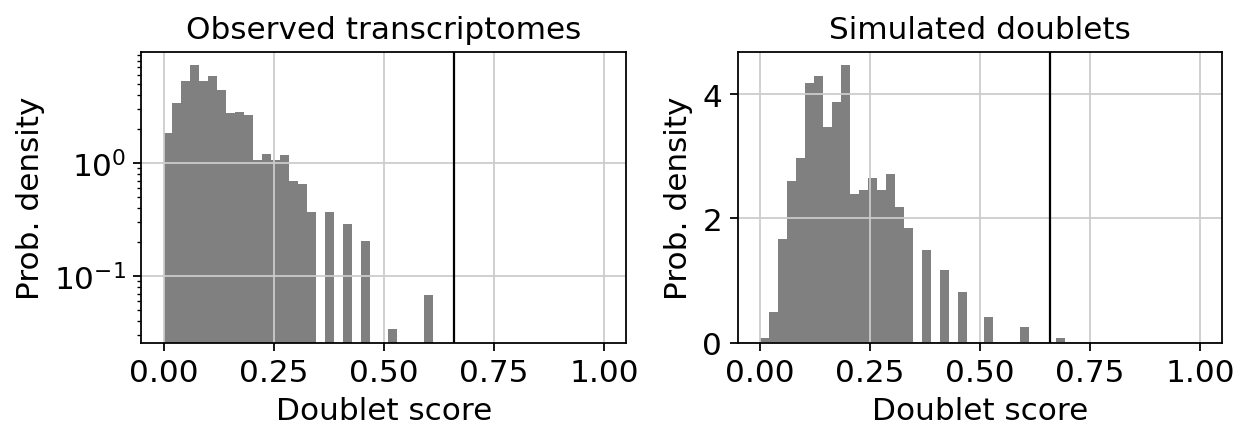

In [43]:
scrub_rcmb18.plot_histogram();

In [44]:
adata_rcmb18.obs['scrublet__predicted_multiplet'] = scrub_rcmb18.predicted_doublets_
adata_rcmb18.obs['scrublet__multiplet_scores'] = scrub_rcmb18.doublet_scores_obs_
adata_rcmb18.obs['scrublet__multiplet_zscores'] = scrub_rcmb18.z_scores_

Trying to set attribute `.obs` of view, copying.


In [45]:
adata_rcmb18.obs

sample technology patient  scrublet__predicted_multiplet  \
AAACCTGAGCGTGAAC-1  RCMB18        PDX  RCMB18                          False   
AAACCTGAGCTGGAAC-1  RCMB18        PDX  RCMB18                          False   
AAACCTGCACCTATCC-1  RCMB18        PDX  RCMB18                          False   
AAACCTGCAGGTGGAT-1  RCMB18        PDX  RCMB18                          False   
AAACCTGGTAAACCTC-1  RCMB18        PDX  RCMB18                          False   
...                    ...        ...     ...                            ...   
TTTGTCAAGTTATCGC-1  RCMB18        PDX  RCMB18                          False   
TTTGTCAGTACATCCA-1  RCMB18        PDX  RCMB18                          False   
TTTGTCATCAGCCTAA-1  RCMB18        PDX  RCMB18                          False   
TTTGTCATCAGCTCGG-1  RCMB18        PDX  RCMB18                          False   
TTTGTCATCTGATTCT-1  RCMB18        PDX  RCMB18                          False   

                    scrublet__multiplet_scores  scrublet__multiplet_zscores  
AAACCTGAGCGTGAAC-1                    0.077640                   -25.822546  
AAACCTGAGCTGGAAC-1                    0.288538                    -4.496297  
AAACCTGCACCTATCC-1                    0.067626                   -30.019887  
AAACCTGCAGGTGGAT-1                    0.140909                   -12.785339  
AAACCTGGTAAACCTC-1                    0.230263                    -6.487376  
...                                        ...                          ...  
TTTGTCAAGTTATCGC-1                    0.098390                   -19.751752  
TTTGTCAGTACATCCA-1                    0.053846                   -38.182921  
TTTGTCATCAGCCTAA-1                    0.007553                  -216.349177  
TTTGTCATCAGCTCGG-1                    0.157635                   -11.062728  
TTTGTCATCTGATTCT-1                    0.247387                    -5.803249  

[2902 rows x 6 columns]

In [46]:
# count the number of predicted multiplets
adata_rcmb18.obs['scrublet__predicted_multiplet'].value_counts() 

False    2902
Name: scrublet__predicted_multiplet, dtype: int64

In [47]:
# remove predicted doublets
adata_rcmb18 = adata_rcmb18[adata_rcmb18.obs['scrublet__predicted_multiplet'] == False]

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [48]:
adata_rcmb18.obs

sample technology patient  scrublet__predicted_multiplet  \
AAACCTGAGCGTGAAC-1  RCMB18        PDX  RCMB18                          False   
AAACCTGAGCTGGAAC-1  RCMB18        PDX  RCMB18                          False   
AAACCTGCACCTATCC-1  RCMB18        PDX  RCMB18                          False   
AAACCTGCAGGTGGAT-1  RCMB18        PDX  RCMB18                          False   
AAACCTGGTAAACCTC-1  RCMB18        PDX  RCMB18                          False   
...                    ...        ...     ...                            ...   
TTTGTCAAGTTATCGC-1  RCMB18        PDX  RCMB18                          False   
TTTGTCAGTACATCCA-1  RCMB18        PDX  RCMB18                          False   
TTTGTCATCAGCCTAA-1  RCMB18        PDX  RCMB18                          False   
TTTGTCATCAGCTCGG-1  RCMB18        PDX  RCMB18                          False   
TTTGTCATCTGATTCT-1  RCMB18        PDX  RCMB18                          False   

                    scrublet__multiplet_scores  scrublet__multiplet_zscores  
AAACCTGAGCGTGAAC-1                    0.077640                   -25.822546  
AAACCTGAGCTGGAAC-1                    0.288538                    -4.496297  
AAACCTGCACCTATCC-1                    0.067626                   -30.019887  
AAACCTGCAGGTGGAT-1                    0.140909                   -12.785339  
AAACCTGGTAAACCTC-1                    0.230263                    -6.487376  
...                                        ...                          ...  
TTTGTCAAGTTATCGC-1                    0.098390                   -19.751752  
TTTGTCAGTACATCCA-1                    0.053846                   -38.182921  
TTTGTCATCAGCCTAA-1                    0.007553                  -216.349177  
TTTGTCATCAGCTCGG-1                    0.157635                   -11.062728  
TTTGTCATCTGATTCT-1                    0.247387                    -5.803249  

[2902 rows x 6 columns]

## READ IN THE DATA FOR BT084-PDX AND PERFORM DOUBLET REMOVAL WITH SCRUBLET

In [49]:
adata_bt084 = sc.read_10x_mtx(
    '/omics/groups/OE0540/internal/projects/chromothripsis_medulloblastoma/data/10XRNA5P/BT084/BT084-PDX/outs/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

adata_bt084.var_names_make_unique()
adata_bt084

# make some metadata
adata_bt084.obs['sample'] = "BT084"
adata_bt084.obs['technology'] = "PDX"
adata_bt084.obs['patient'] = "BT084"

... reading from cache file cache/omics-groups-OE0540-internal-projects-chromothripsis_medulloblastoma-data-10XRNA5P-BT084-BT084-PDX-outs-filtered_feature_bc_matrix-matrix.h5ad


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [50]:
# remove mouse cells
bt084_mouse_cells = pd.read_csv("/omics/groups/OE0540/internal/projects/chromothripsis_medulloblastoma/data/10XRNA5P/BT084/mm10_and_hg19/BT084.mapping.counts.txt", sep = '\t')
bt084_mouse_cells

cell  count.hg19  count.mm10  total.count        ratio
0     AAACCTGAGTCAATAG-1         145         474          619     0.305907
1     AAACCTGGTGCACTTA-1        2726           6         2732   454.333333
2     AAACCTGGTTAAAGAC-1       16046          27        16073   594.296296
3     AAACCTGTCAGAGACG-1         173         553          726     0.312839
4     AAACGGGCACGGATAG-1       10250         211        10461    48.578199
...                  ...         ...         ...          ...          ...
1590  TTTGGTTAGCGAAGGG-1          89         445          534     0.200000
1591  TTTGGTTAGGAGTTTA-1         218         909         1127     0.239824
1592  TTTGTCAAGGCACATG-1         331         404          735     0.819307
1593  TTTGTCACATGCCTAA-1       18940          18        18958  1052.222222
1594  TTTGTCACATTACCTT-1        6603          19         6622   347.526316

[1595 rows x 5 columns]

In [51]:
bt084_mouse_cells = bt084_mouse_cells[bt084_mouse_cells['ratio'] > 1]
bt084_mouse_cells

cell  count.hg19  count.mm10  total.count        ratio
1     AAACCTGGTGCACTTA-1        2726           6         2732   454.333333
2     AAACCTGGTTAAAGAC-1       16046          27        16073   594.296296
4     AAACGGGCACGGATAG-1       10250         211        10461    48.578199
8     AAAGCAACATGGTCAT-1        5656         216         5872    26.185185
9     AAAGTAGAGTCGCCGT-1        5418          35         5453   154.800000
...                  ...         ...         ...          ...          ...
1578  TTTACTGTCCTATTCA-1         290         217          507     1.336406
1579  TTTACTGTCGGCTACG-1       12043          11        12054  1094.818182
1583  TTTCCTCGTAAGTAGT-1       26572          61        26633   435.606557
1593  TTTGTCACATGCCTAA-1       18940          18        18958  1052.222222
1594  TTTGTCACATTACCTT-1        6603          19         6622   347.526316

[723 rows x 5 columns]

In [52]:
bt084_mouse_cells_barcodes = bt084_mouse_cells['cell']
bt084_mouse_cells_barcodes 

1       AAACCTGGTGCACTTA-1
2       AAACCTGGTTAAAGAC-1
4       AAACGGGCACGGATAG-1
8       AAAGCAACATGGTCAT-1
9       AAAGTAGAGTCGCCGT-1
               ...        
1578    TTTACTGTCCTATTCA-1
1579    TTTACTGTCGGCTACG-1
1583    TTTCCTCGTAAGTAGT-1
1593    TTTGTCACATGCCTAA-1
1594    TTTGTCACATTACCTT-1
Name: cell, Length: 723, dtype: object

In [53]:
adata_bt084 = adata_bt084[adata_bt084.obs_names.isin(bt084_mouse_cells_barcodes),:]

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [54]:
adata_bt084

View of AnnData object with n_obs × n_vars = 451 × 32738
    obs: 'sample', 'technology', 'patient'
    var: 'gene_ids', 'feature_types'

In [55]:
scrub_bt084 = scr.Scrublet(
        counts_matrix=adata_bt084.X,
        expected_doublet_rate=0.1,  # Default is 0.1
        random_state=0)

In [56]:
doublet_scores, predicted_doublets = scrub_bt084.scrub_doublets(min_counts=2, 
                                                          min_cells=3, 
                                                          min_gene_variability_pctl=85, 
                                                          n_prin_comps=30)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.43
Detected doublet rate = 1.8%
Estimated detectable doublet fraction = 2.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 72.7%
Elapsed time: 0.3 seconds


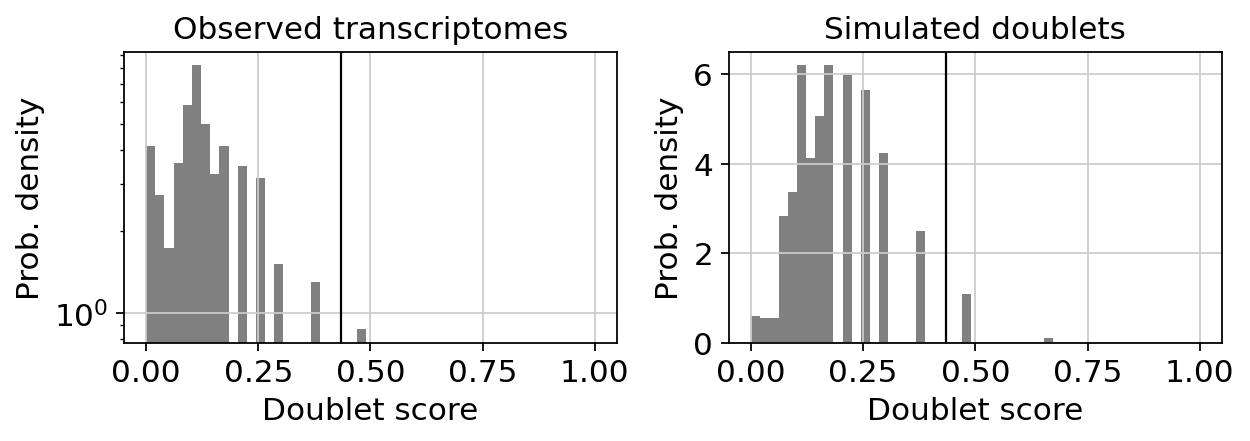

In [57]:
scrub_bt084.plot_histogram();

In [58]:
adata_bt084.obs['scrublet__predicted_multiplet'] = scrub_bt084.predicted_doublets_
adata_bt084.obs['scrublet__multiplet_scores'] = scrub_bt084.doublet_scores_obs_
adata_bt084.obs['scrublet__multiplet_zscores'] = scrub_bt084.z_scores_

Trying to set attribute `.obs` of view, copying.


In [59]:
adata_bt084.obs

sample technology patient  scrublet__predicted_multiplet  \
AAACCTGGTGCACTTA-1  BT084        PDX   BT084                          False   
AAACCTGGTTAAAGAC-1  BT084        PDX   BT084                          False   
AAACGGGCACGGATAG-1  BT084        PDX   BT084                          False   
AAAGCAACATGGTCAT-1  BT084        PDX   BT084                          False   
AAAGTAGAGTCGCCGT-1  BT084        PDX   BT084                          False   
...                   ...        ...     ...                            ...   
TTGTAGGCACTACAGT-1  BT084        PDX   BT084                          False   
TTTACTGTCGGCTACG-1  BT084        PDX   BT084                          False   
TTTCCTCGTAAGTAGT-1  BT084        PDX   BT084                          False   
TTTGTCACATGCCTAA-1  BT084        PDX   BT084                          False   
TTTGTCACATTACCTT-1  BT084        PDX   BT084                          False   

                    scrublet__multiplet_scores  scrublet__multiplet_zscores  
AAACCTGGTGCACTTA-1                    0.061889                   -15.968084  
AAACCTGGTTAAAGAC-1                    0.250000                    -1.869656  
AAACGGGCACGGATAG-1                    0.211679                    -2.694944  
AAAGCAACATGGTCAT-1                    0.096234                    -9.352708  
AAAGTAGAGTCGCCGT-1                    0.138298                    -5.626654  
...                                        ...                          ...  
TTGTAGGCACTACAGT-1                    0.096234                    -9.352708  
TTTACTGTCGGCTACG-1                    0.121951                    -6.771696  
TTTCCTCGTAAGTAGT-1                    0.250000                    -1.869656  
TTTGTCACATGCCTAA-1                    0.211679                    -2.694944  
TTTGTCACATTACCTT-1                    0.121951                    -6.771696  

[451 rows x 6 columns]

In [60]:
adata_bt084.obs['scrublet__predicted_multiplet'].value_counts() 

False    443
True       8
Name: scrublet__predicted_multiplet, dtype: int64

In [61]:
# remove predicted doublets
adata_bt084 = adata_bt084[adata_bt084.obs['scrublet__predicted_multiplet'] == False]

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [62]:
adata_bt084.obs

sample technology patient  scrublet__predicted_multiplet  \
AAACCTGGTGCACTTA-1  BT084        PDX   BT084                          False   
AAACCTGGTTAAAGAC-1  BT084        PDX   BT084                          False   
AAACGGGCACGGATAG-1  BT084        PDX   BT084                          False   
AAAGCAACATGGTCAT-1  BT084        PDX   BT084                          False   
AAAGTAGAGTCGCCGT-1  BT084        PDX   BT084                          False   
...                   ...        ...     ...                            ...   
TTGTAGGCACTACAGT-1  BT084        PDX   BT084                          False   
TTTACTGTCGGCTACG-1  BT084        PDX   BT084                          False   
TTTCCTCGTAAGTAGT-1  BT084        PDX   BT084                          False   
TTTGTCACATGCCTAA-1  BT084        PDX   BT084                          False   
TTTGTCACATTACCTT-1  BT084        PDX   BT084                          False   

                    scrublet__multiplet_scores  scrublet__multiplet_zscores  
AAACCTGGTGCACTTA-1                    0.061889                   -15.968084  
AAACCTGGTTAAAGAC-1                    0.250000                    -1.869656  
AAACGGGCACGGATAG-1                    0.211679                    -2.694944  
AAAGCAACATGGTCAT-1                    0.096234                    -9.352708  
AAAGTAGAGTCGCCGT-1                    0.138298                    -5.626654  
...                                        ...                          ...  
TTGTAGGCACTACAGT-1                    0.096234                    -9.352708  
TTTACTGTCGGCTACG-1                    0.121951                    -6.771696  
TTTCCTCGTAAGTAGT-1                    0.250000                    -1.869656  
TTTGTCACATGCCTAA-1                    0.211679                    -2.694944  
TTTGTCACATTACCTT-1                    0.121951                    -6.771696  

[443 rows x 6 columns]

In [63]:
# Merge all of the data together.
adata = adata_stp.concatenate([adata_st1r, adata_rcmb18, adata_bt084], join="outer")

In [64]:
adata.obs

sample technology patient  scrublet__predicted_multiplet  \
AAACCTGCACGTTGGC-1-0    STP        PDX      ST                          False   
AAACCTGCATCATCCC-1-0    STP        PDX      ST                          False   
AAACCTGGTGCACTTA-1-0    STP        PDX      ST                          False   
AAACCTGTCAATACCG-1-0    STP        PDX      ST                          False   
AAACCTGTCGCGTAGC-1-0    STP        PDX      ST                          False   
...                     ...        ...     ...                            ...   
TTGTAGGCACTACAGT-1-3  BT084        PDX   BT084                          False   
TTTACTGTCGGCTACG-1-3  BT084        PDX   BT084                          False   
TTTCCTCGTAAGTAGT-1-3  BT084        PDX   BT084                          False   
TTTGTCACATGCCTAA-1-3  BT084        PDX   BT084                          False   
TTTGTCACATTACCTT-1-3  BT084        PDX   BT084                          False   

                      scrublet__multiplet_scores  scrublet__multiplet_zscores  \
AAACCTGCACGTTGGC-1-0                    0.060000                   -26.020484   
AAACCTGCATCATCCC-1-0                    0.126516                   -10.700572   
AAACCTGGTGCACTTA-1-0                    0.227882                    -4.367256   
AAACCTGTCAATACCG-1-0                    0.273292                    -3.049375   
AAACCTGTCGCGTAGC-1-0                    0.227882                    -4.367256   
...                                          ...                          ...   
TTGTAGGCACTACAGT-1-3                    0.096234                    -9.352708   
TTTACTGTCGGCTACG-1-3                    0.121951                    -6.771696   
TTTCCTCGTAAGTAGT-1-3                    0.250000                    -1.869656   
TTTGTCACATGCCTAA-1-3                    0.211679                    -2.694944   
TTTGTCACATTACCTT-1-3                    0.121951                    -6.771696   

                     batch  
AAACCTGCACGTTGGC-1-0     0  
AAACCTGCATCATCCC-1-0     0  
AAACCTGGTGCACTTA-1-0     0  
AAACCTGTCAATACCG-1-0     0  
AAACCTGTCGCGTAGC-1-0     0  
...                    ...  
TTGTAGGCACTACAGT-1-3     3  
TTTACTGTCGGCTACG-1-3     3  
TTTCCTCGTAAGTAGT-1-3     3  
TTTGTCACATGCCTAA-1-3     3  
TTTGTCACATTACCTT-1-3     3  

[9761 rows x 7 columns]

## START PERFORMING THE INITIAL QUALITY CONTROL

normalizing counts per cell
    finished (0:00:00)


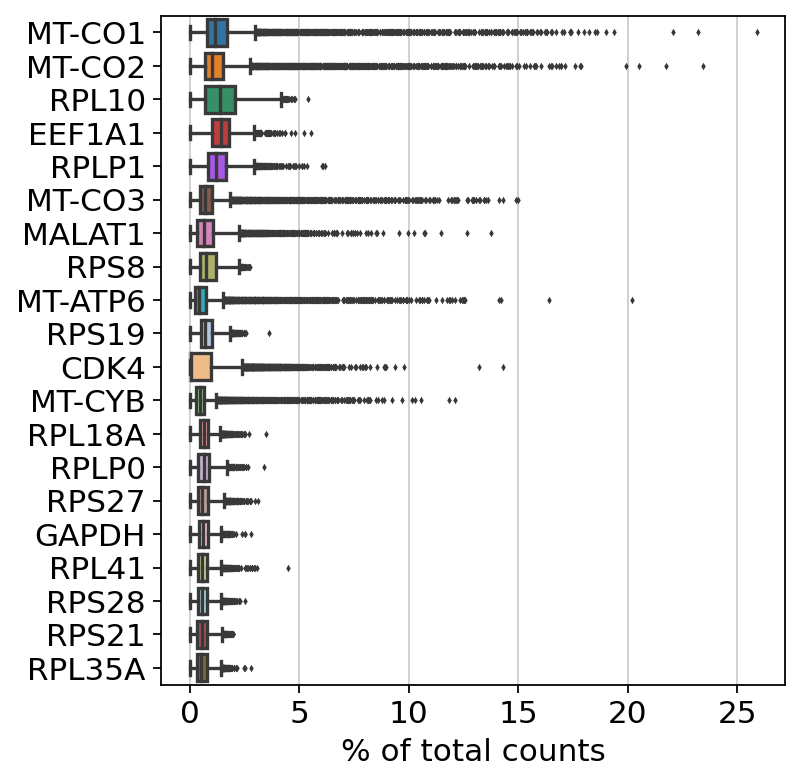

In [65]:
# preprocessing
sc.pl.highest_expr_genes(adata, n_top=20)

In [66]:
# basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 75 cells that have less than 200 genes expressed


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/przybilm/.local/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


filtered out 12960 genes that are detected in less than 3 cells


In [67]:
# calculate some quality metrics as for instance mitochondrial percentage
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# and for ribosomal genes
adata.var['ribo'] = adata.var_names.str.startswith(('RPS','RPL'))  # annotate the group of ribosomal genes as 'ribo'
sc.pp.calculate_qc_metrics(adata, qc_vars=['ribo'], percent_top=None, log1p=False, inplace=True)

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'sample' as categorical
... storing 'technology' as categorical
... storing 'patient' as categorical
... storing 'feature_types' as categorical


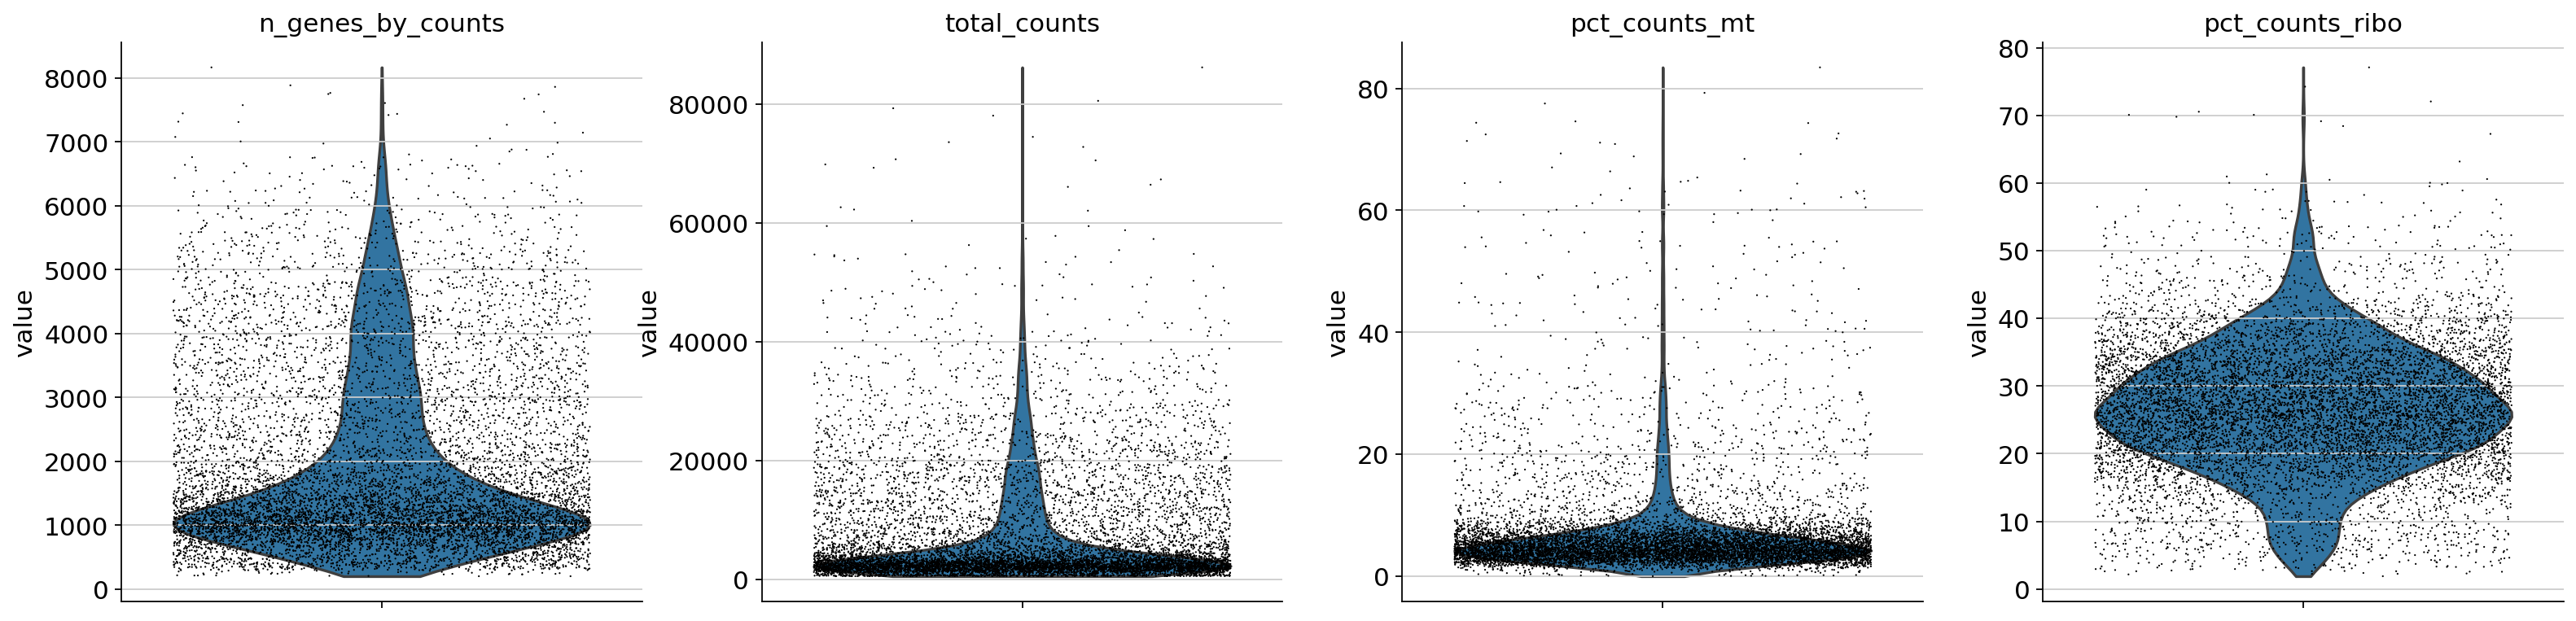

In [68]:
# visualize some QC metrics
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'],
             jitter=0.4, multi_panel=True)

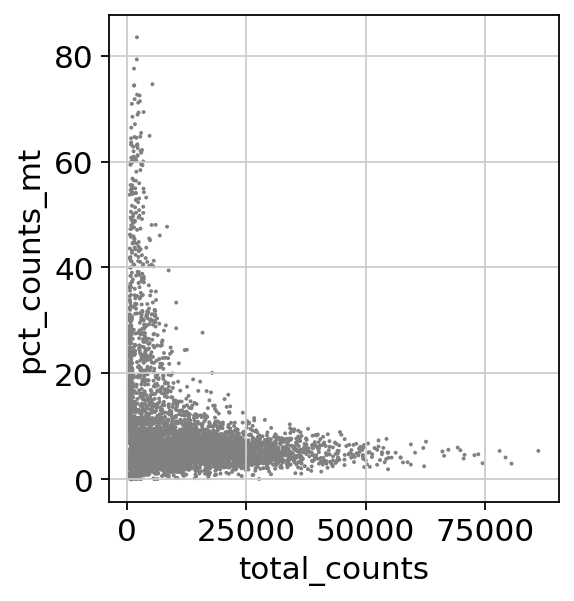

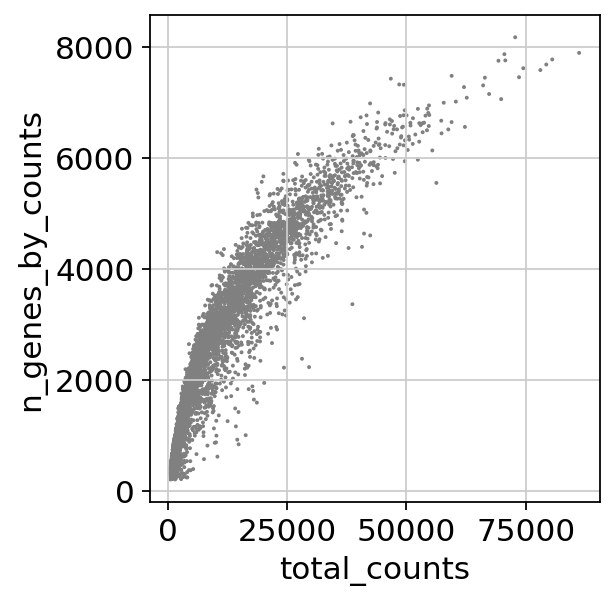

In [69]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [70]:
# do the actual filtering by slicing the object
adata = adata[200 < adata.obs.n_genes_by_counts, :]
adata = adata[500 < adata.obs.total_counts, :]
adata = adata[adata.obs.total_counts < 25000, :]
adata = adata[adata.obs.pct_counts_mt < 10, :]
adata = adata[adata.obs.pct_counts_ribo < 40, :]

In [71]:
adata

View of AnnData object with n_obs × n_vars = 7226 × 19778
    obs: 'sample', 'technology', 'patient', 'scrublet__predicted_multiplet', 'scrublet__multiplet_scores', 'scrublet__multiplet_zscores', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribo'

In [72]:
# calculate mean number of genes detected
mean_genes = adata.obs['n_genes'].mean()
print(mean_genes)

# calculate mean number of transcripts detected
mean_counts = adata.obs['total_counts'].mean()
print(mean_counts)

1825.8221699418766
5822.505859375


## PERFORM NORMALIZATION, PCA AND CLUSTERING

In [73]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell


/home/przybilm/.local/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)


In [74]:
sc.pp.log1p(adata)

In [75]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


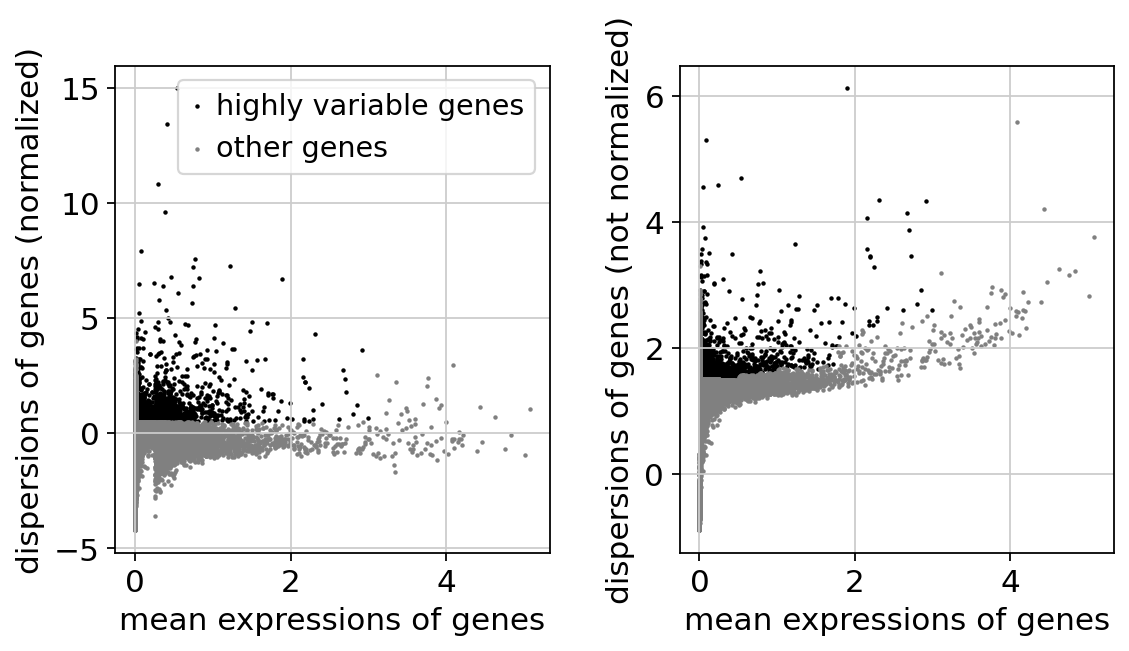

In [76]:
sc.pl.highly_variable_genes(adata)

In [77]:
# set the raw attribute of anndata
adata.raw = adata

In [78]:
adata = adata[:, adata.var.highly_variable]

In [79]:
# regress out effects of total counts per cell and the percentage of mitochondrial genes
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt', 'pct_counts_ribo'])

regressing out ['total_counts', 'pct_counts_mt', 'pct_counts_ribo']
    sparse input is densified and may lead to high memory use
    finished (0:00:20)


In [80]:
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:05)


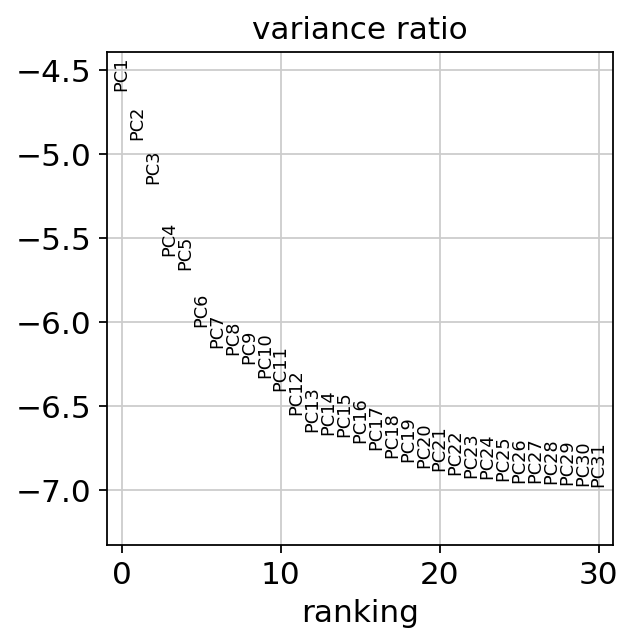

In [81]:
sc.pl.pca_variance_ratio(adata, log=True)

In [82]:
# compute nearest neighbors, UMAP and clustering
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=15)
sc.tl.umap(adata,
            n_components=2,
            min_dist=0.1,  # Scanpy default = 0.05
            spread=1.0,
            copy=False,
            random_state=0
        )
sc.tl.louvain(adata, resolution= 0.6)
sc.tl.leiden(adata, resolution= 0.6)

computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:14)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 15 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


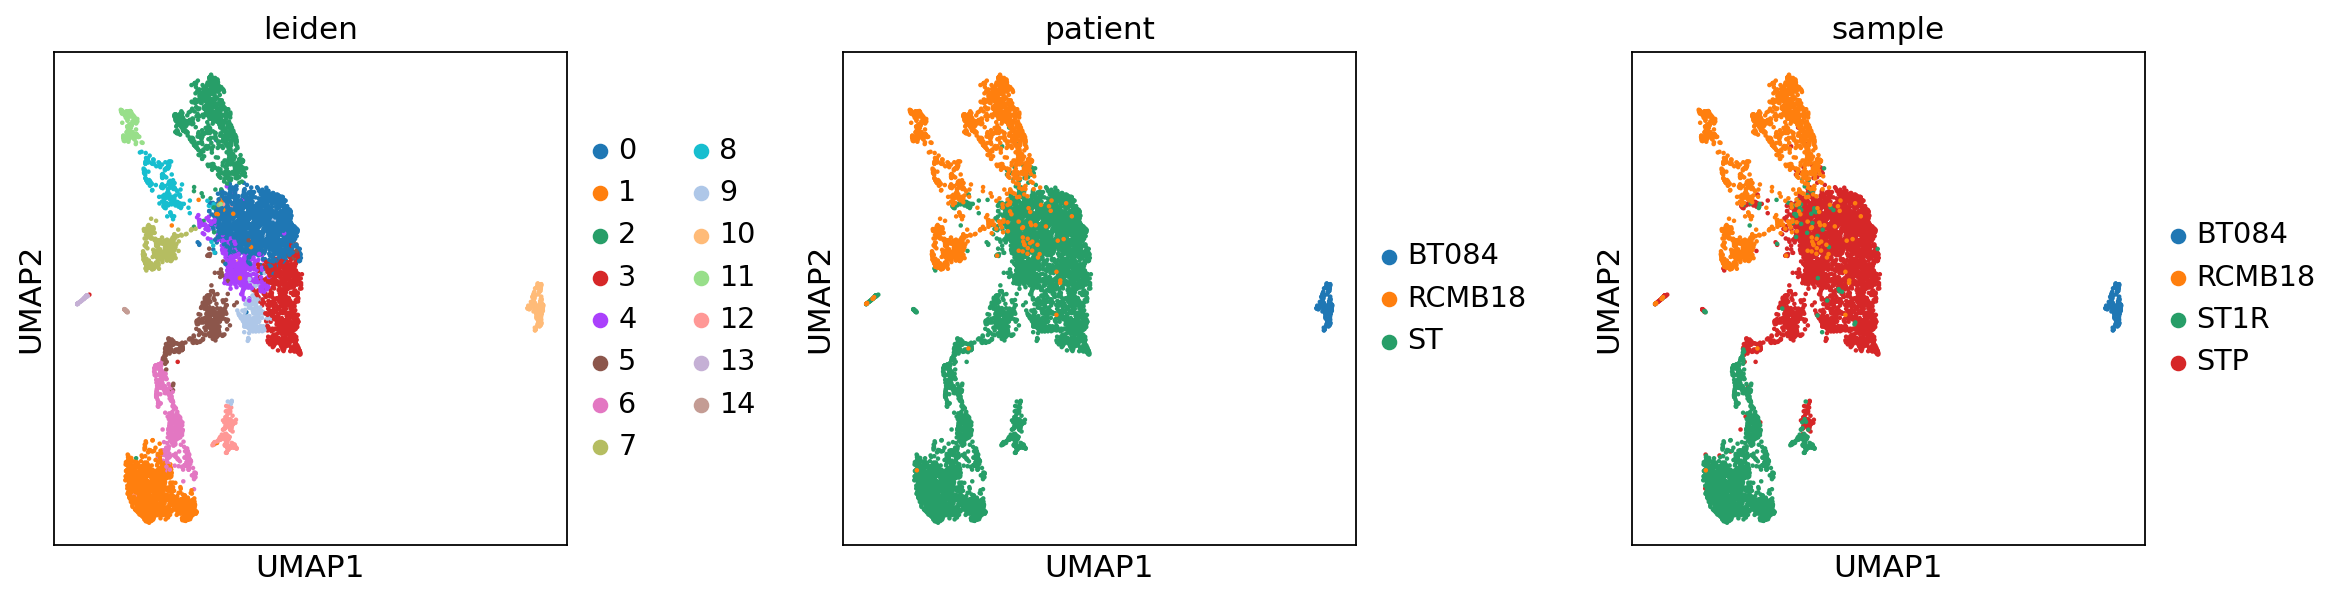

In [83]:
sc.pl.umap(adata, color=['leiden', 'patient', "sample"], save = '_PDX_merge.pdf', wspace = 0.4)

In [84]:
adata.obs

sample technology patient  scrublet__predicted_multiplet  \
AAACCTGCACGTTGGC-1-0    STP        PDX      ST                          False   
AAACCTGGTGCACTTA-1-0    STP        PDX      ST                          False   
AAACCTGTCAATACCG-1-0    STP        PDX      ST                          False   
AAACCTGTCGCGTAGC-1-0    STP        PDX      ST                          False   
AAACGGGAGGTCATCT-1-0    STP        PDX      ST                          False   
...                     ...        ...     ...                            ...   
TTCTTAGGTGGTCCGT-1-3  BT084        PDX   BT084                          False   
TTGAACGGTCGATTGT-1-3  BT084        PDX   BT084                          False   
TTGTAGGCACTACAGT-1-3  BT084        PDX   BT084                          False   
TTTCCTCGTAAGTAGT-1-3  BT084        PDX   BT084                          False   
TTTGTCACATGCCTAA-1-3  BT084        PDX   BT084                          False   

                      scrublet__multiplet_scores  scrublet__multiplet_zscores  \
AAACCTGCACGTTGGC-1-0                    0.060000                   -26.020484   
AAACCTGGTGCACTTA-1-0                    0.227882                    -4.367256   
AAACCTGTCAATACCG-1-0                    0.273292                    -3.049375   
AAACCTGTCGCGTAGC-1-0                    0.227882                    -4.367256   
AAACGGGAGGTCATCT-1-0                    0.193396                    -5.780644   
...                                          ...                          ...   
TTCTTAGGTGGTCCGT-1-3                    0.108108                    -8.011000   
TTGAACGGTCGATTGT-1-3                    0.138298                    -5.626654   
TTGTAGGCACTACAGT-1-3                    0.096234                    -9.352708   
TTTCCTCGTAAGTAGT-1-3                    0.250000                    -1.869656   
TTTGTCACATGCCTAA-1-3                    0.211679                    -2.694944   

                     batch  n_genes  n_genes_by_counts  total_counts  \
AAACCTGCACGTTGGC-1-0     0      565                565         745.0   
AAACCTGGTGCACTTA-1-0     0      943                943        2068.0   
AAACCTGTCAATACCG-1-0     0     1036               1034        2298.0   
AAACCTGTCGCGTAGC-1-0     0     1031               1031        2481.0   
AAACGGGAGGTCATCT-1-0     0      974                974        2096.0   
...                    ...      ...                ...           ...   
TTCTTAGGTGGTCCGT-1-3     3     2697               2697       11227.0   
TTGAACGGTCGATTGT-1-3     3     3781               3781       23036.0   
TTGTAGGCACTACAGT-1-3     3     4641               4629       24541.0   
TTTCCTCGTAAGTAGT-1-3     3     3464               3463       22869.0   
TTTGTCACATGCCTAA-1-3     3     4712               4710       18543.0   

                      total_counts_mt  pct_counts_mt  total_counts_ribo  \
AAACCTGCACGTTGGC-1-0             16.0       2.147651               87.0   
AAACCTGGTGCACTTA-1-0            151.0       7.301741              691.0   
AAACCTGTCAATACCG-1-0            101.0       4.395126              748.0   
AAACCTGTCGCGTAGC-1-0            101.0       4.070939              842.0   
AAACGGGAGGTCATCT-1-0            152.0       7.251909              655.0   
...                               ...            ...                ...   
TTCTTAGGTGGTCCGT-1-3            678.0       6.039013             3098.0   
TTGAACGGTCGATTGT-1-3           1559.0       6.767668             6531.0   
TTGTAGGCACTACAGT-1-3            929.0       3.785502             4924.0   
TTTCCTCGTAAGTAGT-1-3           1753.0       7.665399             7412.0   
TTTGTCACATGCCTAA-1-3           1429.0       7.706412             3575.0   

                      pct_counts_ribo louvain leiden  
AAACCTGCACGTTGGC-1-0        11.677853       0      0  
AAACCTGGTGCACTTA-1-0        33.413925       0      0  
AAACCTGTCAATACCG-1-0        32.550041       0      0  
AAACCTGTCGCGTAGC-1-0        33.937927       0      0  
AAACGGGAGGTCATCT-1-0        31.250

ranking genes


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:14)


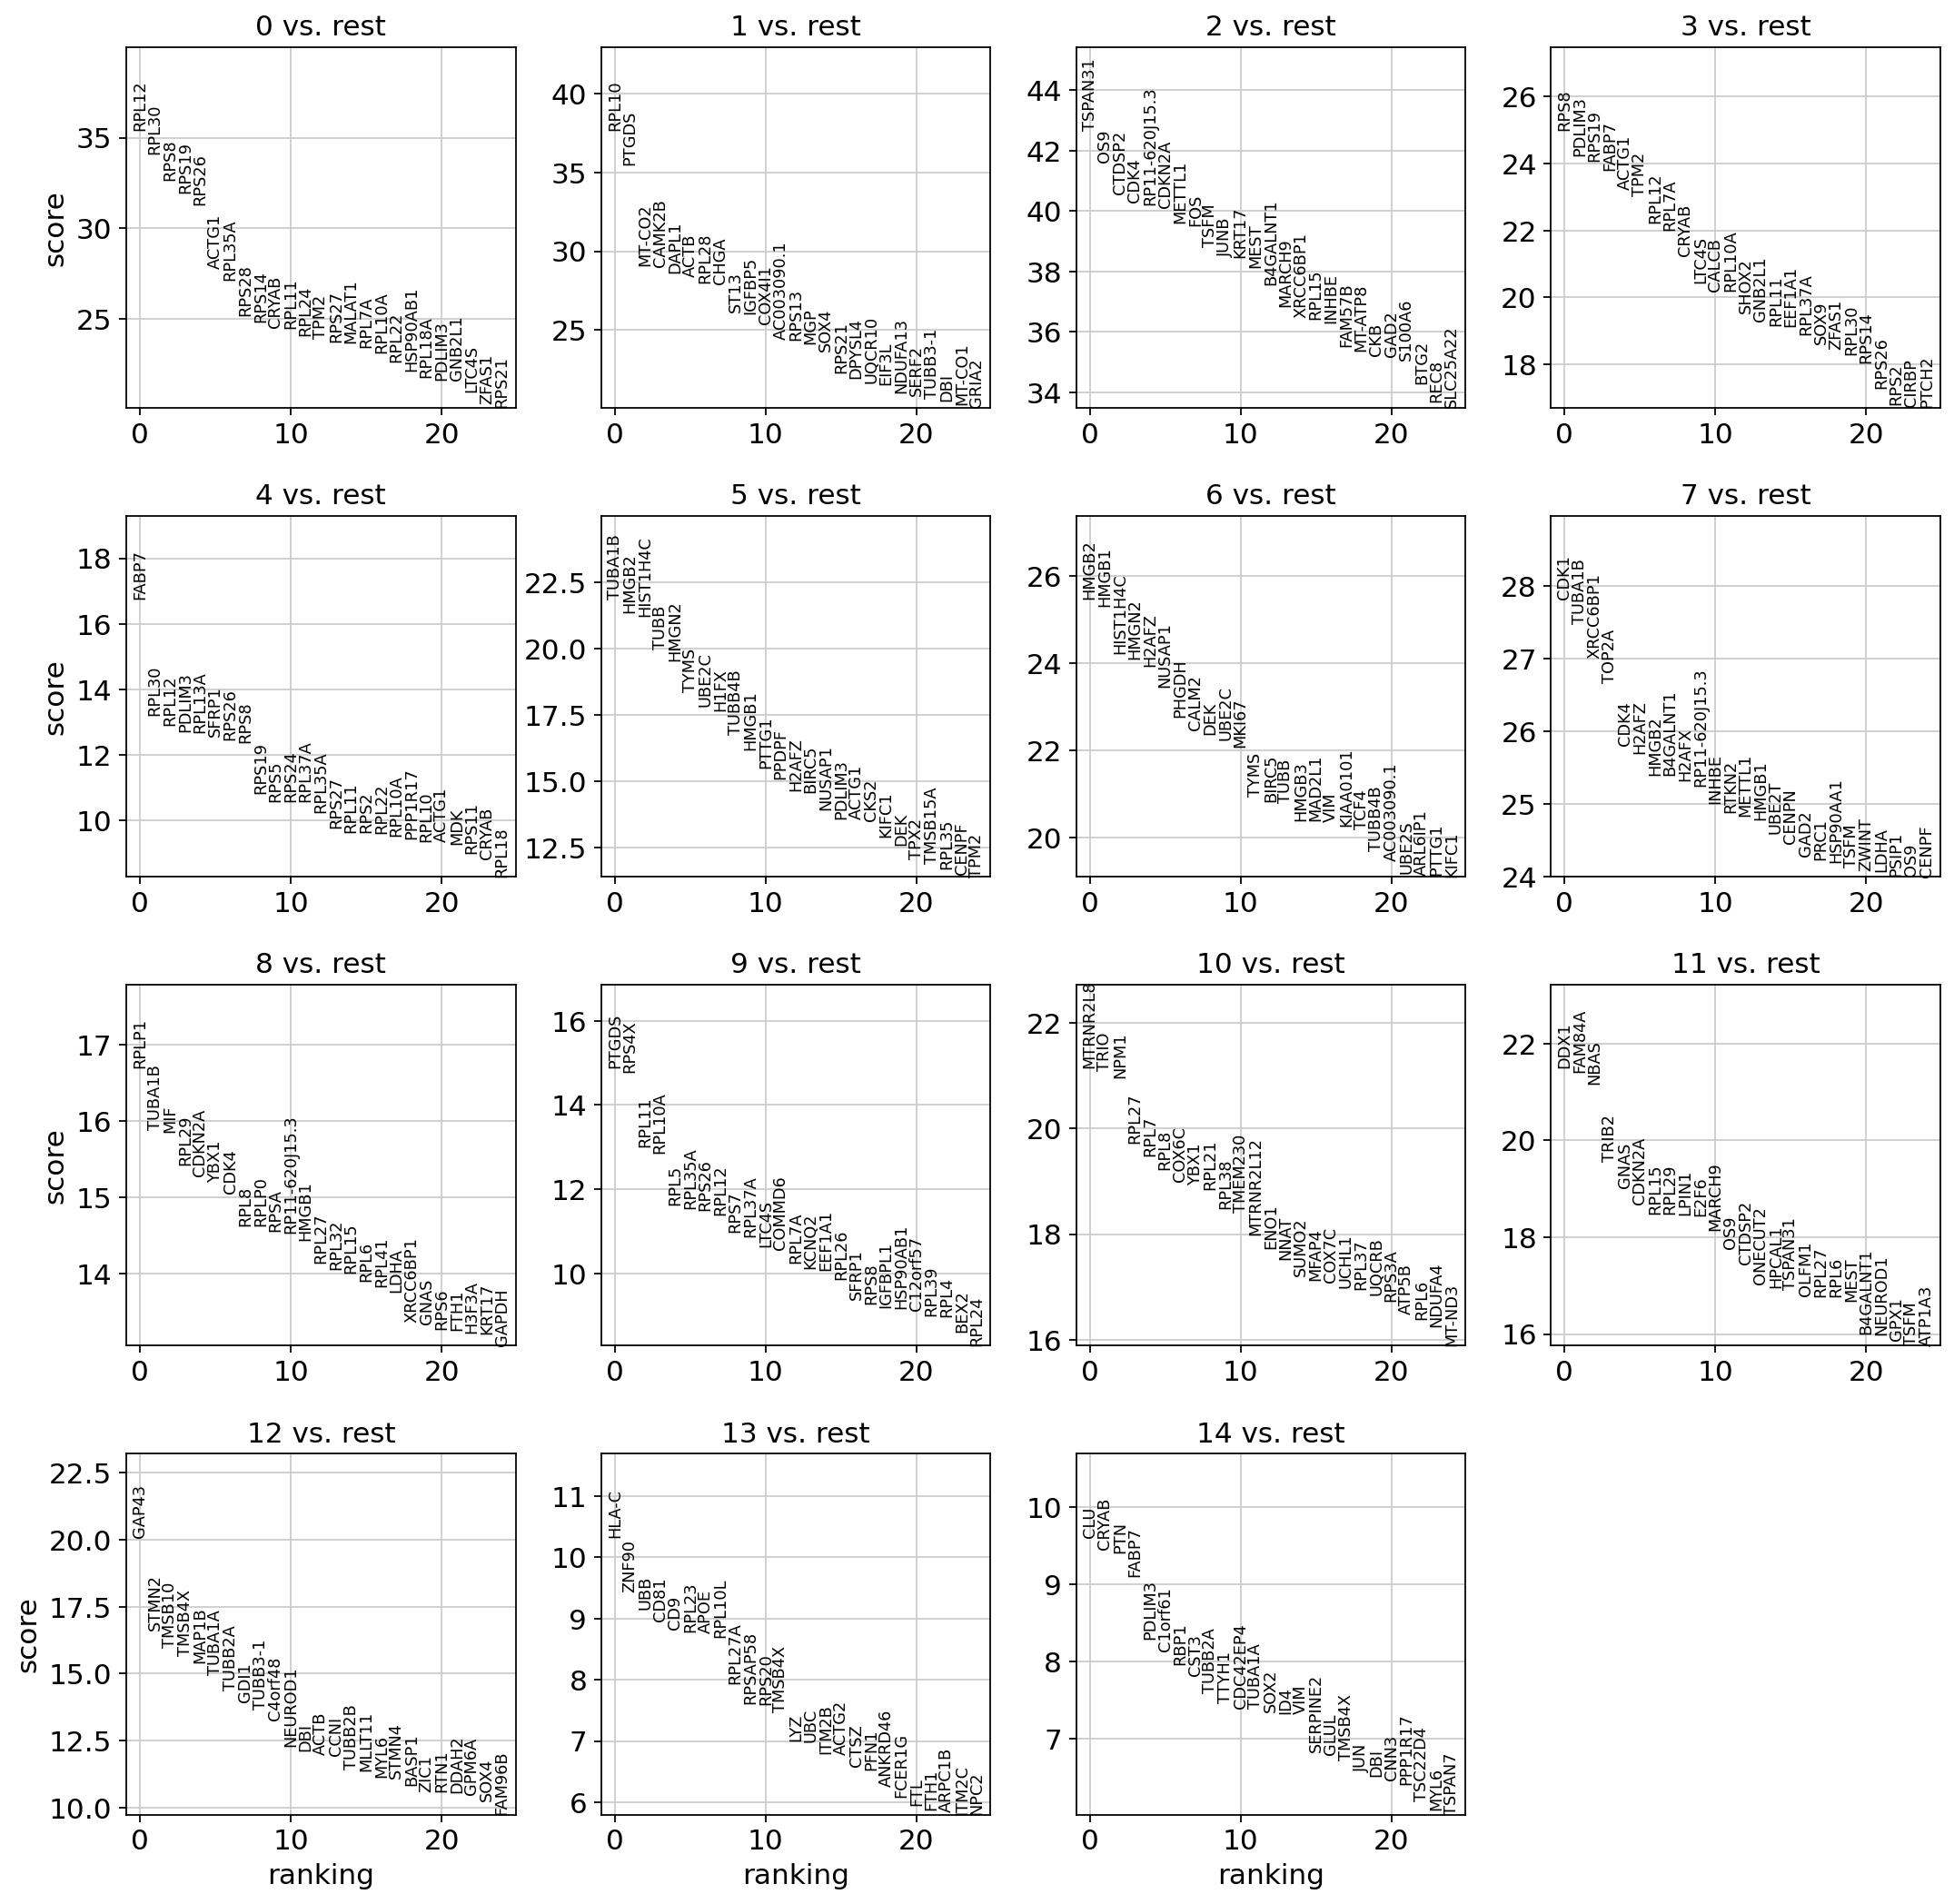

In [85]:
# find marker genes for each cluster using the Wilcoxon rank sum test
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, save = "_PDX.pdf")

In [86]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
wilcoxon_df = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', "scores", 'logfoldchanges', "pvals", 'pvals_adj']})

In [87]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(25)

0           1              2       3        4         5  \
0      RPL12       RPL10        TSPAN31    RPS8    FABP7    TUBA1B   
1      RPL30       PTGDS            OS9  PDLIM3    RPL30     HMGB2   
2       RPS8      MT-CO2         CTDSP2   RPS19    RPL12  HIST1H4C   
3      RPS19      CAMK2B           CDK4   FABP7   PDLIM3      TUBB   
4      RPS26       DAPL1  RP11-620J15.3   ACTG1   RPL13A     HMGN2   
5      ACTG1        ACTB         CDKN2A    TPM2    SFRP1      TYMS   
6     RPL35A       RPL28         METTL1   RPL12    RPS26     UBE2C   
7      RPS28        CHGA            FOS   RPL7A     RPS8      H1FX   
8      RPS14        ST13           TSFM   CRYAB    RPS19    TUBB4B   
9      CRYAB      IGFBP5           JUNB   LTC4S     RPS5     HMGB1   
10     RPL11      COX4I1          KRT17   CALCB    RPS24     PTTG1   
11     RPL24  AC003090.1           MEST  RPL10A   RPL37A     PPDPF   
12      TPM2       RPS13       B4GALNT1   SHOX2   RPL35A     H2AFZ   
13     RPS27         MGP         MARCH9  GNB2L1    RPS27     BIRC5   
14    MALAT1        SOX4       XRCC6BP1   RPL11    RPL11    NUSAP1   
15     RPL7A       RPS21          RPL15  EEF1A1     RPS2    PDLIM3   
16    RPL10A      DPYSL4          INHBE  RPL37A    RPL22     ACTG1   
17     RPL22      UQCR10         FAM57B    SOX9   RPL10A      CKS2   
18  HSP90AB1       EIF3L        MT-ATP8   ZFAS1  PPP1R17     KIFC1   
19    RPL18A     NDUFA13            CKB   RPL30    RPL10       DEK   
20    PDLIM3       SERF2           GAD2   RPS14    ACTG1      TPX2   
21    GNB2L1     TUBB3-1         S100A6   RPS26      MDK   TMSB15A   
22     LTC4S         DBI           BTG2    RPS2    RPS11     RPL35   
23     ZFAS1      MT-CO1           REC8   CIRBP    CRYAB     CENPF   
24     RPS21       GRIA2       SLC25A22   PTCH2    RPL18      TPM2   

             6              7              8         9         10        11  \
0        HMGB2           CDK1          RPLP1     PTGDS   MTRNR2L8      DDX1   
1        HMGB1         TUBA1B         TUBA1B     RPS4X       TRIO    FAM84A   
2     HIST1H4C       XRCC6BP1            MIF     RPL11       NPM1      NBAS   
3        HMGN2          TOP2A          RPL29    RPL10A      RPL27     TRIB2   
4        H2AFZ           CDK4         CDKN2A      RPL5       RPL7      GNAS   
5       NUSAP1          H2AFZ           YBX1    RPL35A       RPL8    CDKN2A   
6        PHGDH          HMGB2           CDK4     RPS26      COX6C     RPL15   
7        CALM2       B4GALNT1           RPL8     RPL12       YBX1     RPL29   
8          DEK          H2AFX          RPLP0      RPS7      RPL21     LPIN1   
9        UBE2C  RP11-620J15.3           RPSA    RPL37A      RPL38      E2F6   
10       MKI67          INHBE  RP11-620J15.3     LTC4S    TMEM230    MARCH9   
11        TYMS          RTKN2          HMGB1    COMMD6  MTRNR2L12       OS9   
12       BIRC5         METTL1          RPL27     RPL7A       ENO1    CTDSP2   
13        TUBB          HMGB1          RPL32     KCNQ2       NNAT   ONECUT2   
14       HMGB3          UBE2T          RPL15    EEF1A1      SUMO2    HPCAL1   
15      MAD2L1          CENPN           RPL6     RPL26      MFAP4   TSPAN31   
16         VIM           GAD2          RPL41     SFRP1      COX7C     OLFM1   
17    KIAA0101           PRC1           LDHA      RPS8      UCHL1     RPL27   
18        TCF4       HSP90AA1       XRCC6BP1   IGFBPL1      RPL37      RPL6   
19      TUBB4B           TSFM           GNAS  HSP90AB1      UQCRB      MEST   
20  AC003090.1          ZWINT           RPS6  C12orf57      RPS3A  B4GALNT1   
21       UBE2S           LDHA           FTH1     RPL39      ATP5B   NEUROD1   
22     ARL6IP1          PSIP1          H3F3A      RPL4       RPL6      GPX1   
23       PTTG1            OS9          KRT17      BEX2     NDUFA4      TSFM   
24       KIFC1          CENPF          GAPDH     RPL24     MT-ND3    ATP1A3   

         12       13        14  
0     GAP43    HLA-C       CLU  
1     STMN2    ZNF90     CRYAB  
2    TMSB10      UBB       PTN  
3  

In [88]:
wilcoxon_df.to_csv("/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/revision/scrna_analysis/scanpy/PDX_DEG_wilcoxon.csv")

In [89]:
new_cluster_names = ['cluster0', 'cluster1', 'cluster2', 'cluster3', 'cluster4', 'cluster5', 'cluster6', 'cluster7',
                     'cluster8',  'cluster9', 'cluster10', 'cluster11', 'cluster12', 'cluster13', 'cluster14']
adata.rename_categories('leiden', new_cluster_names)

old_to_new = dict(
    cluster0='Cluster0',
    cluster1='Cluster1',
    cluster2='Cluster2',
    cluster3='Cluster0',
    cluster4='Cluster0',
    cluster5='Cluster3',
    cluster6='Cluster1',
    cluster7='Cluster4',
    cluster8='Cluster4', 
    cluster9='Cluster0',
    cluster10='Cluster5',
    cluster11='Cluster6',
    cluster12='Cluster7',
    cluster13='Cluster8',
    cluster14='Cluster9'
)

adata.obs['adapted_clusters'] = (
    adata.obs['leiden']
    .map(old_to_new)
    .astype('category')
)


/home/przybilm/.local/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


ranking genes


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:13)


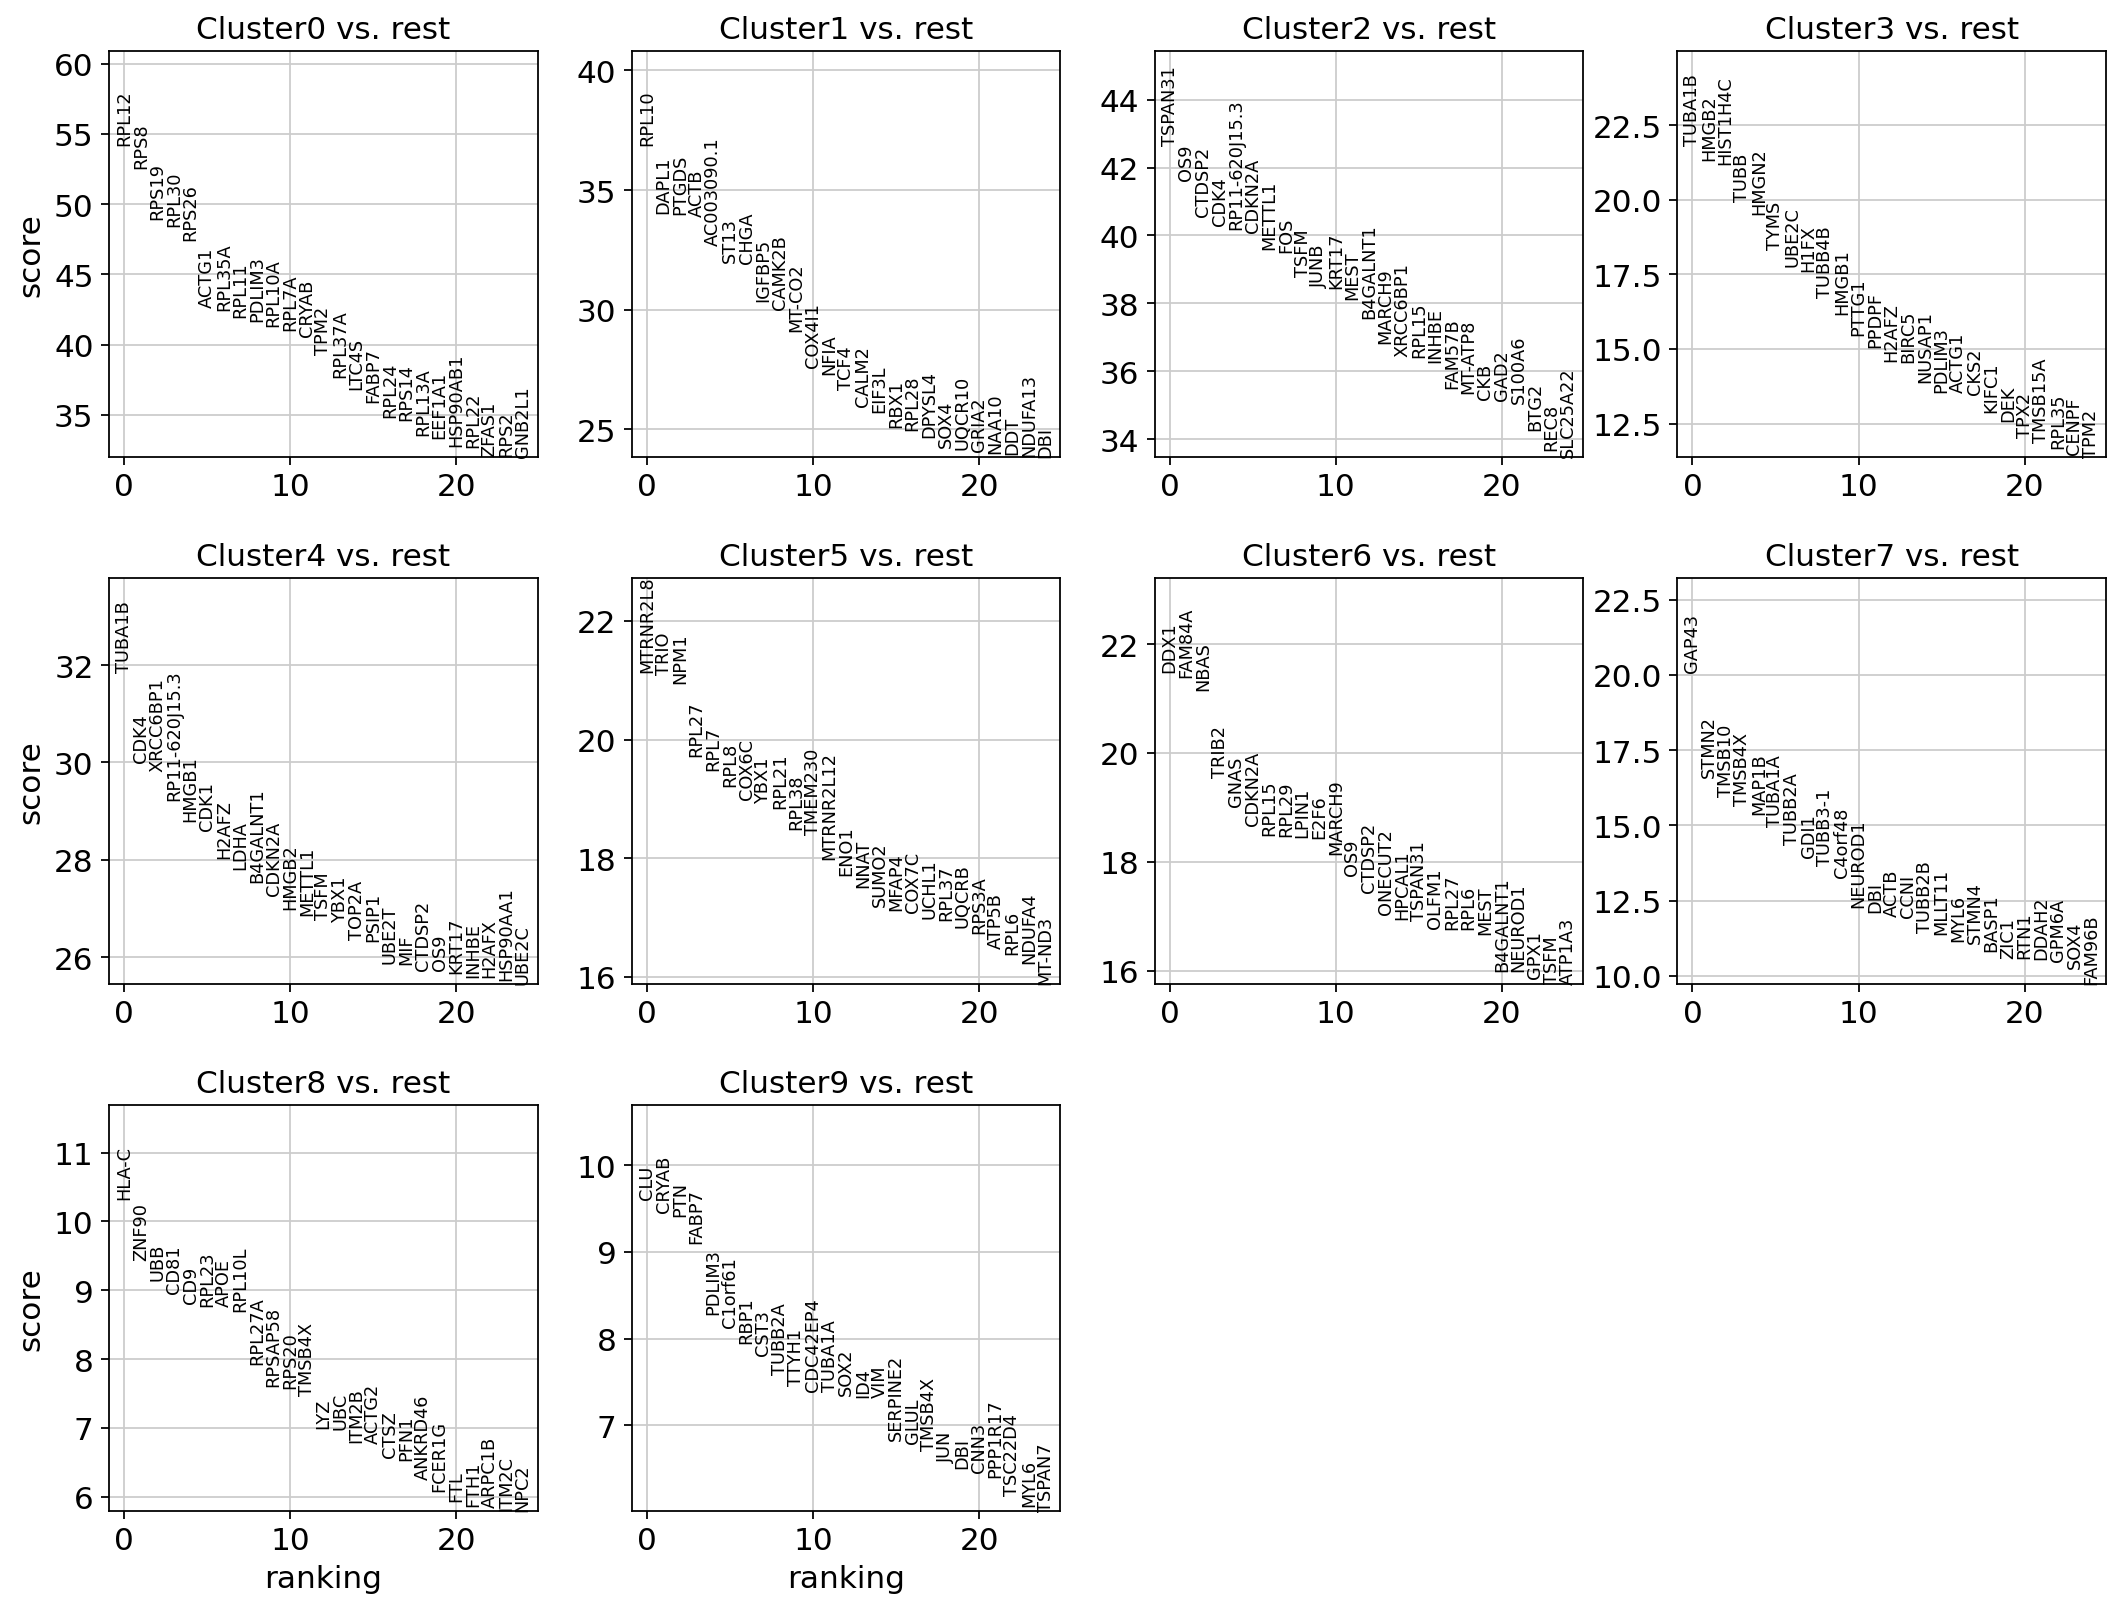

In [90]:
# find marker genes for each cluster using the Wilcoxon rank sum test
sc.tl.rank_genes_groups(adata, 'adapted_clusters', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [91]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
wilcoxon_df = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', "scores", 'logfoldchanges', "pvals", 'pvals_adj']})

In [92]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(25)

Cluster0    Cluster1       Cluster2  Cluster3       Cluster4   Cluster5  \
0      RPL12       RPL10        TSPAN31    TUBA1B         TUBA1B   MTRNR2L8   
1       RPS8       DAPL1            OS9     HMGB2           CDK4       TRIO   
2      RPS19       PTGDS         CTDSP2  HIST1H4C       XRCC6BP1       NPM1   
3      RPL30        ACTB           CDK4      TUBB  RP11-620J15.3      RPL27   
4      RPS26  AC003090.1  RP11-620J15.3     HMGN2          HMGB1       RPL7   
5      ACTG1        ST13         CDKN2A      TYMS           CDK1       RPL8   
6     RPL35A        CHGA         METTL1     UBE2C          H2AFZ      COX6C   
7      RPL11      IGFBP5            FOS      H1FX           LDHA       YBX1   
8     PDLIM3      CAMK2B           TSFM    TUBB4B       B4GALNT1      RPL21   
9     RPL10A      MT-CO2           JUNB     HMGB1         CDKN2A      RPL38   
10     RPL7A      COX4I1          KRT17     PTTG1          HMGB2    TMEM230   
11     CRYAB        NFIA           MEST     PPDPF         METTL1  MTRNR2L12   
12      TPM2        TCF4       B4GALNT1     H2AFZ           TSFM       ENO1   
13    RPL37A       CALM2         MARCH9     BIRC5           YBX1       NNAT   
14     LTC4S       EIF3L       XRCC6BP1    NUSAP1          TOP2A      SUMO2   
15     FABP7        RBX1          RPL15    PDLIM3          PSIP1      MFAP4   
16     RPL24       RPL28          INHBE     ACTG1          UBE2T      COX7C   
17     RPS14      DPYSL4         FAM57B      CKS2            MIF      UCHL1   
18    RPL13A        SOX4        MT-ATP8     KIFC1         CTDSP2      RPL37   
19    EEF1A1      UQCR10            CKB       DEK            OS9      UQCRB   
20  HSP90AB1       GRIA2           GAD2      TPX2          KRT17      RPS3A   
21     RPL22       NAA10         S100A6   TMSB15A          INHBE      ATP5B   
22     ZFAS1         DDT           BTG2     RPL35          H2AFX       RPL6   
23      RPS2     NDUFA13           REC8     CENPF       HSP90AA1     NDUFA4   
24    GNB2L1         DBI       SLC25A22      TPM2          UBE2C     MT-ND3   

    Cluster6 Cluster7 Cluster8  Cluster9  
0       DDX1    GAP43    HLA-C       CLU  
1     FAM84A    STMN2    ZNF90     CRYAB  
2       NBAS   TMSB10      UBB       PTN  
3      TRIB2   TMSB4X     CD81     FABP7  
4       GNAS    MAP1B      CD9    PDLIM3  
5     CDKN2A   TUBA1A    RPL23   C1orf61  
6      RPL15   TUBB2A     APOE      RBP1  
7      RPL29     GDI1   RPL10L      CST3  
8      LPIN1  TUBB3-1   RPL27A    TUBB2A  
9       E2F6  C4orf48  RPSAP58     TTYH1  
10    MARCH9  NEUROD1    RPS20  CDC42EP4  
11       OS9      DBI   TMSB4X    TUBA1A  
12    CTDSP2     ACTB      LYZ      SOX2  
13   ONECUT2     CCNI      UBC       ID4  
14    HPCAL1   TUBB2B    ITM2B       VIM  
15   TSPAN31   MLLT11    ACTG2  SERPINE2  
16     OLFM1     MYL6     CTSZ      GLUL  
17     RPL27    STMN4     PFN1    TMSB4X  
18      RPL6    BASP1  ANKRD46       JUN  
19      MEST     ZIC1   FCER1G       DBI  
20  B4GALNT1     RTN1      FTL      CNN3  
21   NEUROD1    DDAH2     FTH1   PPP1R17  
22      GPX1    GPM6A   ARPC1B   TSC22D4  
23      TSFM     SOX4    ITM2C      MYL6  
24    ATP1A3   FAM96B     NPC2    TSPAN7

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


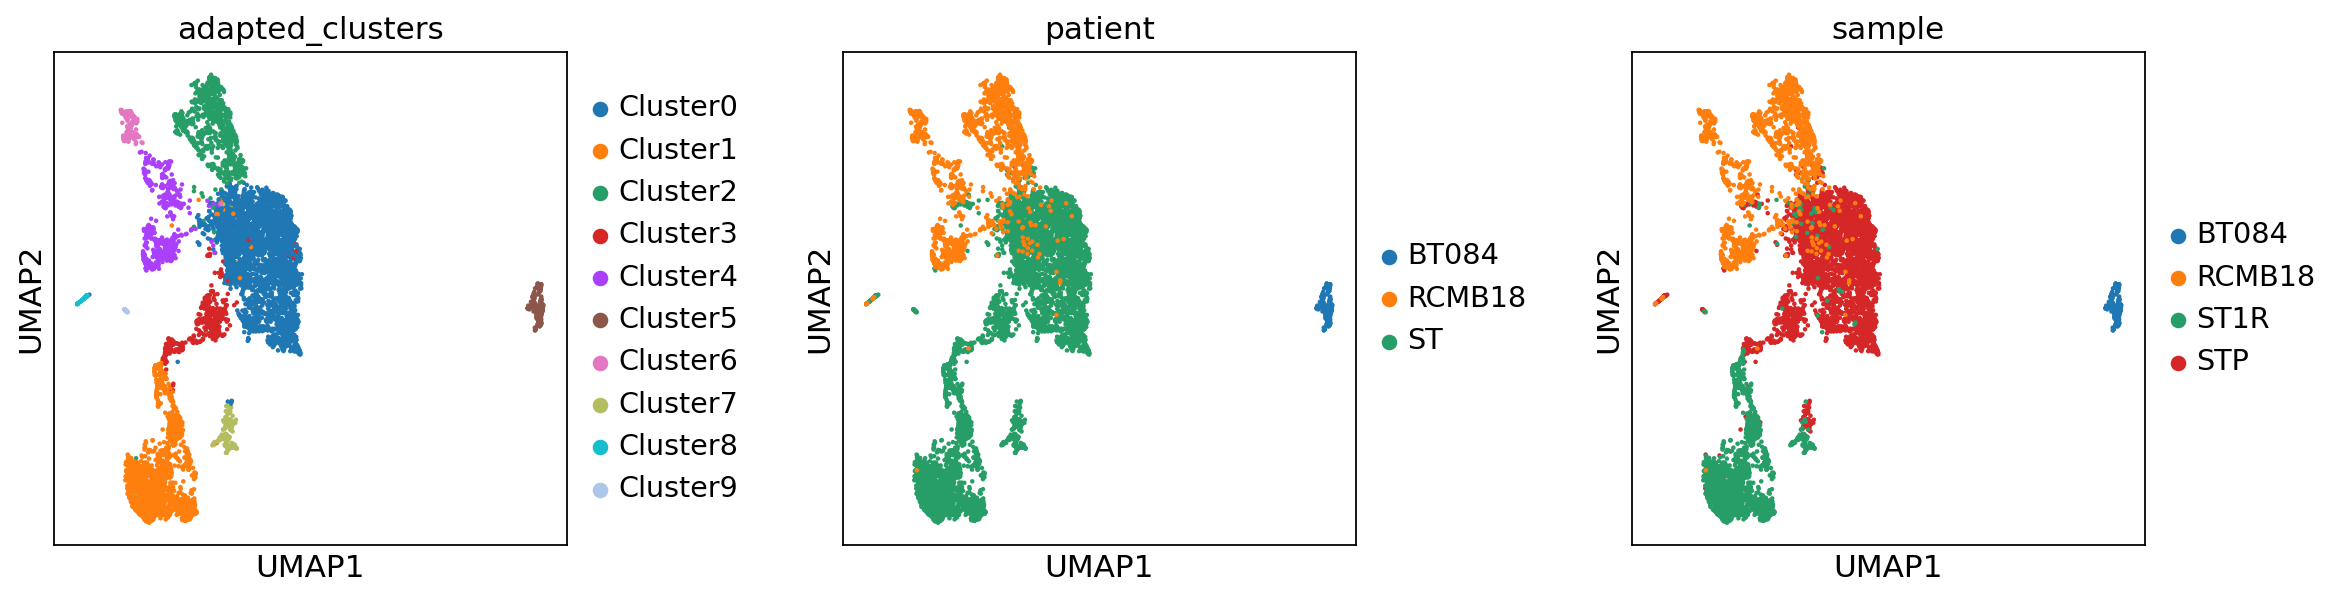

In [93]:
sc.pl.umap(adata, color=['adapted_clusters', 'patient', "sample"], save = '_PDX_merge.pdf', wspace = 0.4)

In [94]:
old_to_new = dict(
    Cluster0='Malignant Basal State',
    Cluster1='Malignant Neuronal Development I',
    Cluster2='Malignant Neuronal Development II',
    Cluster3='Malignant Basal State',
    Cluster4='Malignant Cycling',
    Cluster5='Malignant Granule-like Progenitor',
    Cluster6='Malignant Neuronal Development III',
    Cluster7='Granule Cells',
    Cluster8='Microglia',
    Cluster9='Astrocytes'
)

adata.obs['Cell_types'] = (
    adata.obs['adapted_clusters']
    .map(old_to_new)
    .astype('category')
)


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


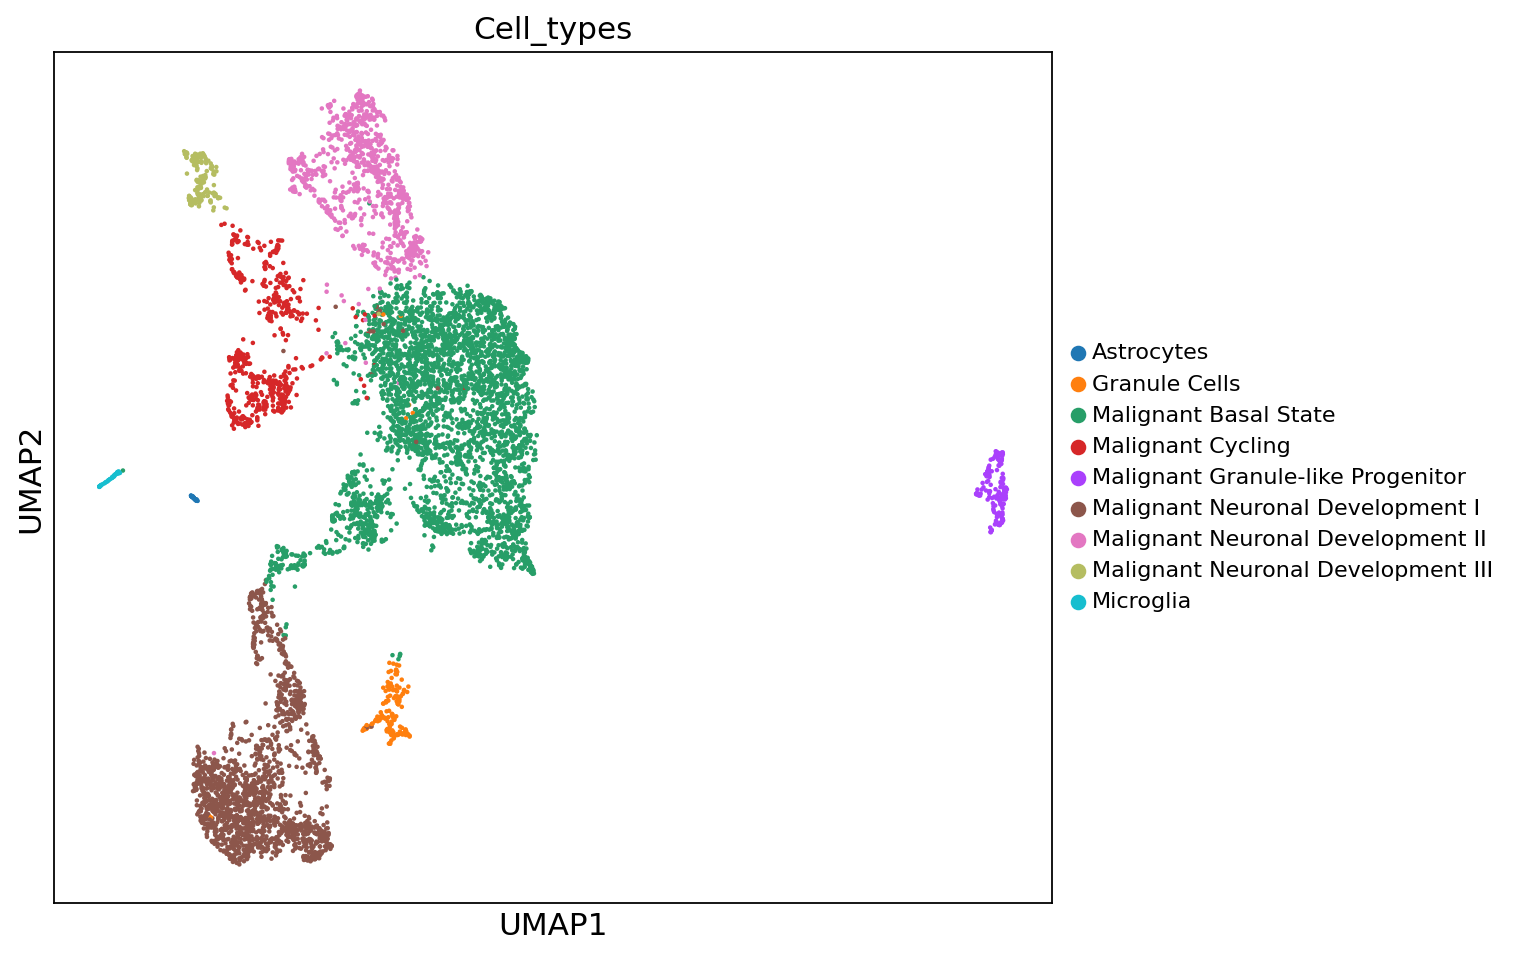

In [95]:
rcParams['figure.figsize'] = 8,7
sc.pl.umap(adata, color=['Cell_types'], save = '_PDX_Figure3.pdf', legend_fontsize = 10)

In [96]:
adata.write('/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/revision/scrna_analysis/PDX_Celltype_scanpy.h5ad')  # the file that will store the analysis results)

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


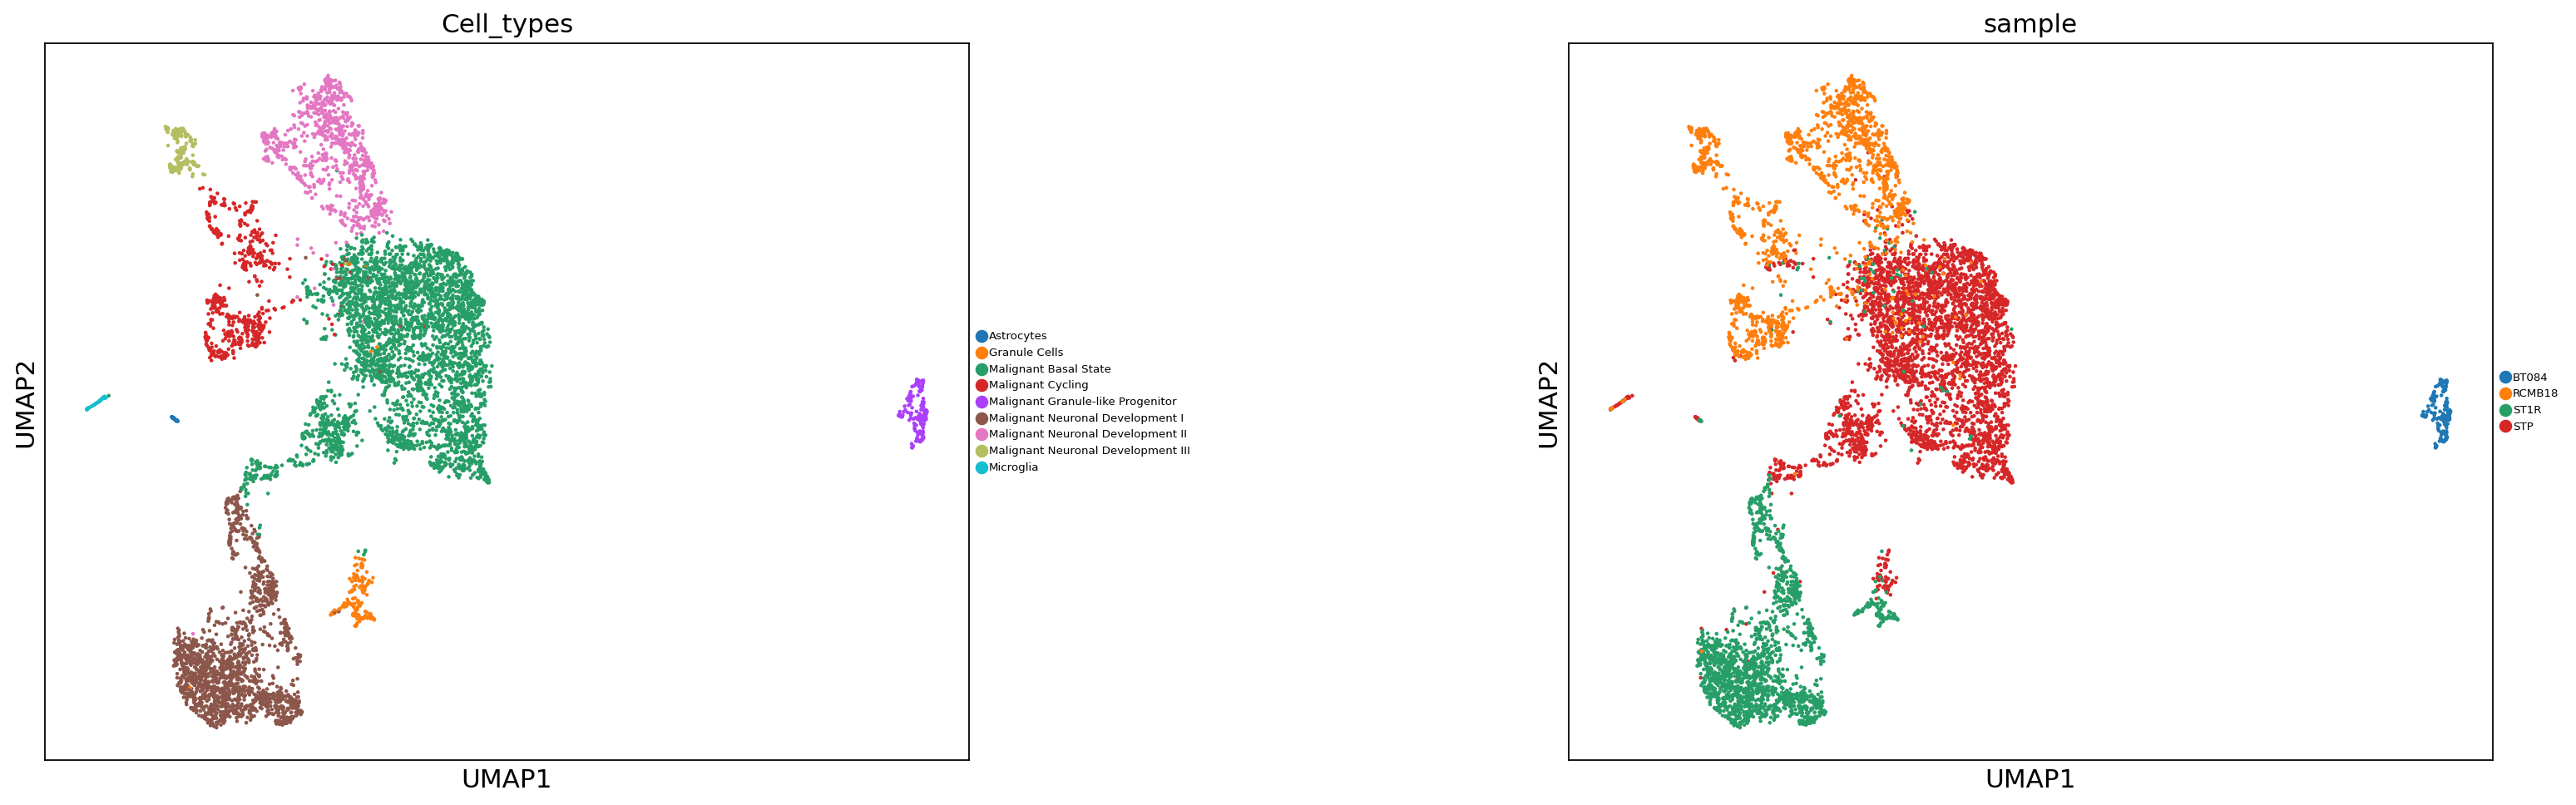

In [97]:
sc.pl.umap(adata, color=['Cell_types', "sample"], save = '_PDX_CellType.pdf', wspace = 0.5, legend_fontsize = 6)

In [171]:
metadata = pd.DataFrame(adata.obs, index=adata.obs_names)
metadata.to_csv('/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/revision/scrna_analysis/scanpy/PDX_metadata_final.csv')

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


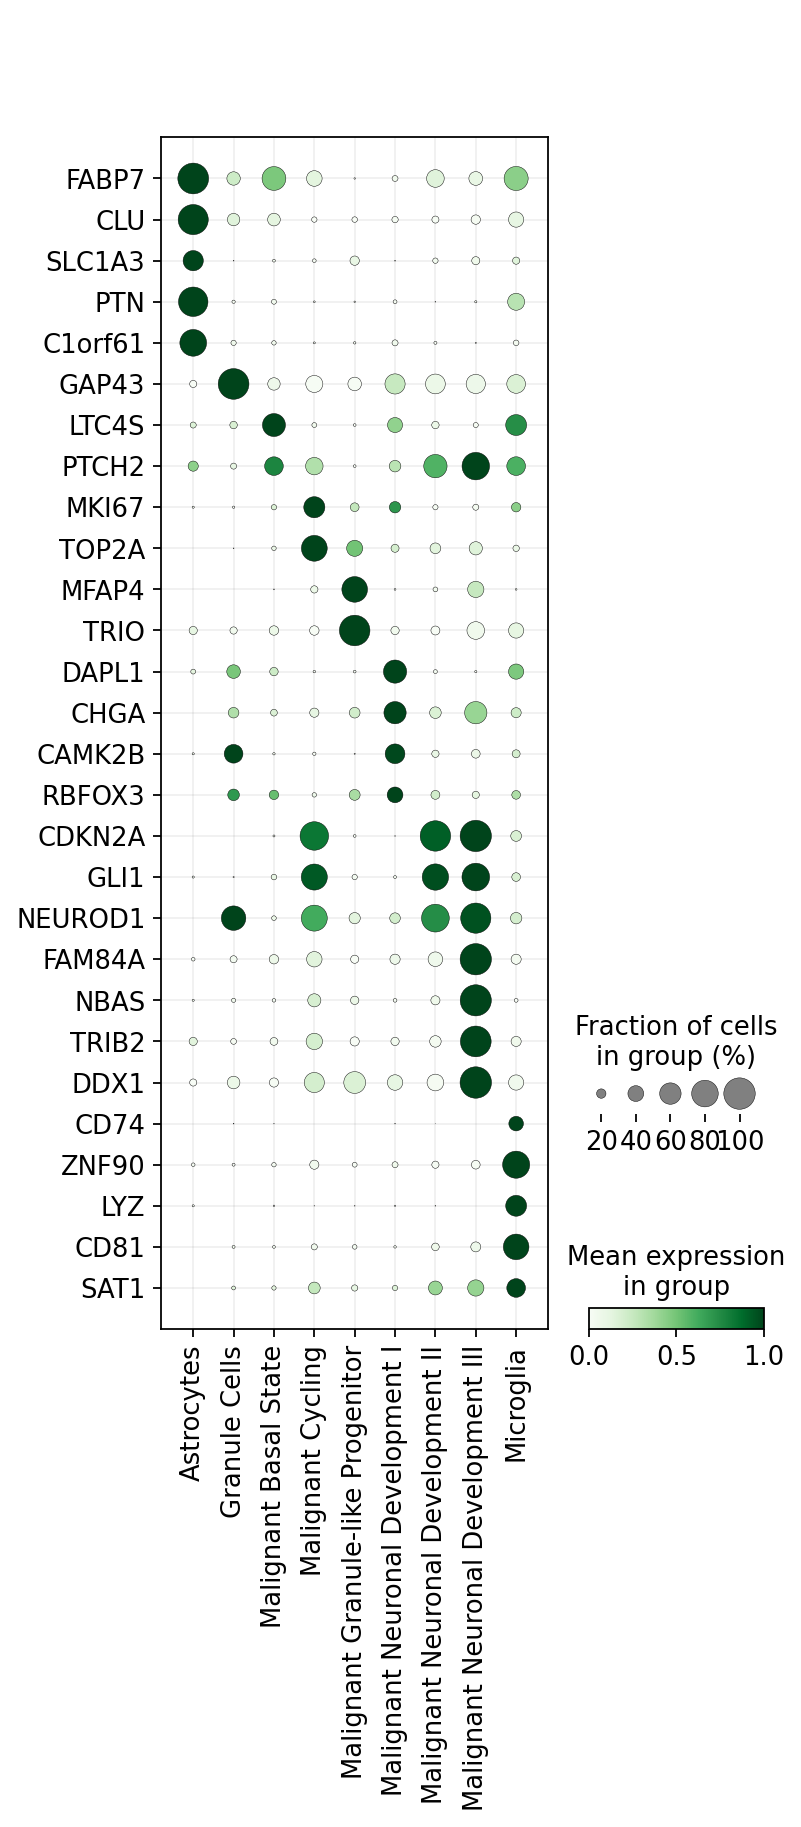

In [170]:
aurelie_celltype_genes = ["FABP7", "CLU", "SLC1A3", "PTN", "C1orf61", # Astrocytes
                          "GAP43", # Granule Cells
                          "LTC4S", "PTCH2", # Basal State
                          "MKI67", "TOP2A", # Cycling
                          'MFAP4', 'TRIO', # Malignant Granule-like Progenitor
                          "DAPL1", "CHGA", 'CAMK2B', 'RBFOX3', # Neuronal Development I
                          "CDKN2A", 'GLI1', "NEUROD1", # Neuronal Development II
                          'FAM84A', 'NBAS', 'TRIB2', 'DDX1', # Neuronal Development III
                          "CD74", "ZNF90", "LYZ", "CD81", "SAT1"] # Microglia

rcParams["figure.figsize"] = 12, 9
sc.pl.dotplot(adata, aurelie_celltype_genes, groupby='Cell_types', standard_scale='var', return_fig=True).style(grid=True, cmap='Greens', color_on='dot').swap_axes(swap_axes=True).savefig("PDX_Celltype_MarkerGenes.pdf")

In [172]:
# run sccaf on the clustering
y_prob, y_pred, y_test, clf, cvsm, acc = SCCAF_assessment(adata.X, adata.obs['Cell_types'], n=100)

Mean CV accuracy: 0.8371
Accuracy on the training set: 1.0000
Accuracy on the hold-out set: 0.6002


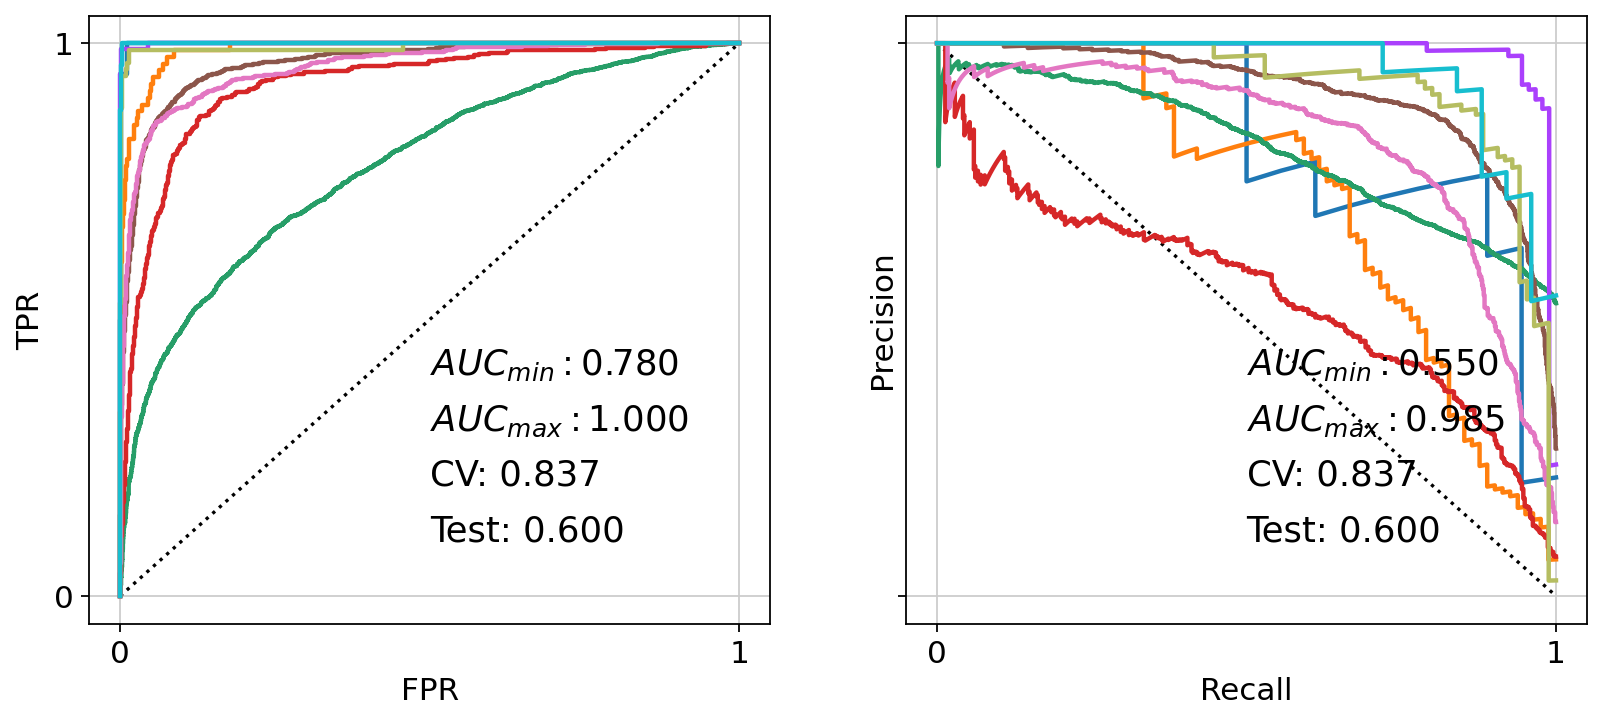

In [175]:
import matplotlib.pyplot as plt
rcParams['figure.figsize'] = 12,5
plot_roc(y_prob, y_test, clf, cvsm=cvsm, acc=acc)
plt.savefig('/home/przybilm/jupyter/PDX/figures/sccaf_performance_PDX.pdf',  dpi=600, format='pdf')

running Leiden clustering
    finished: found 15 clusters and added
    'L2_Round0', the cluster labels (adata.obs, categorical) (0:00:01)
R1norm_cutoff: 0.500000
R2norm_cutoff: 0.050000
Accuracy: 0.000000
Round1 ...
Mean CV accuracy: 0.8477
Accuracy on the training set: 0.9354
Accuracy on the hold-out set: 0.7823


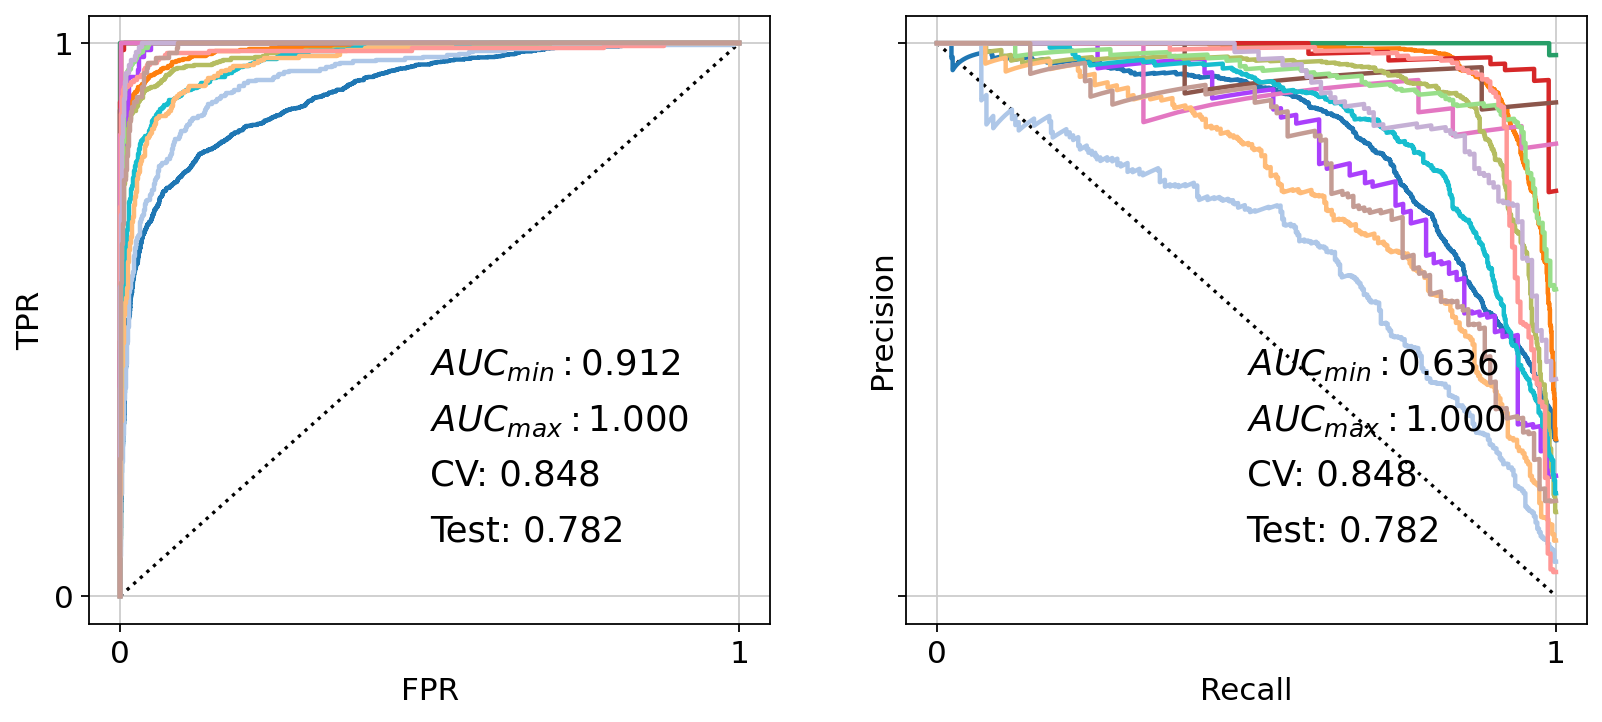

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'L2_Round0_self-projection' as categorical


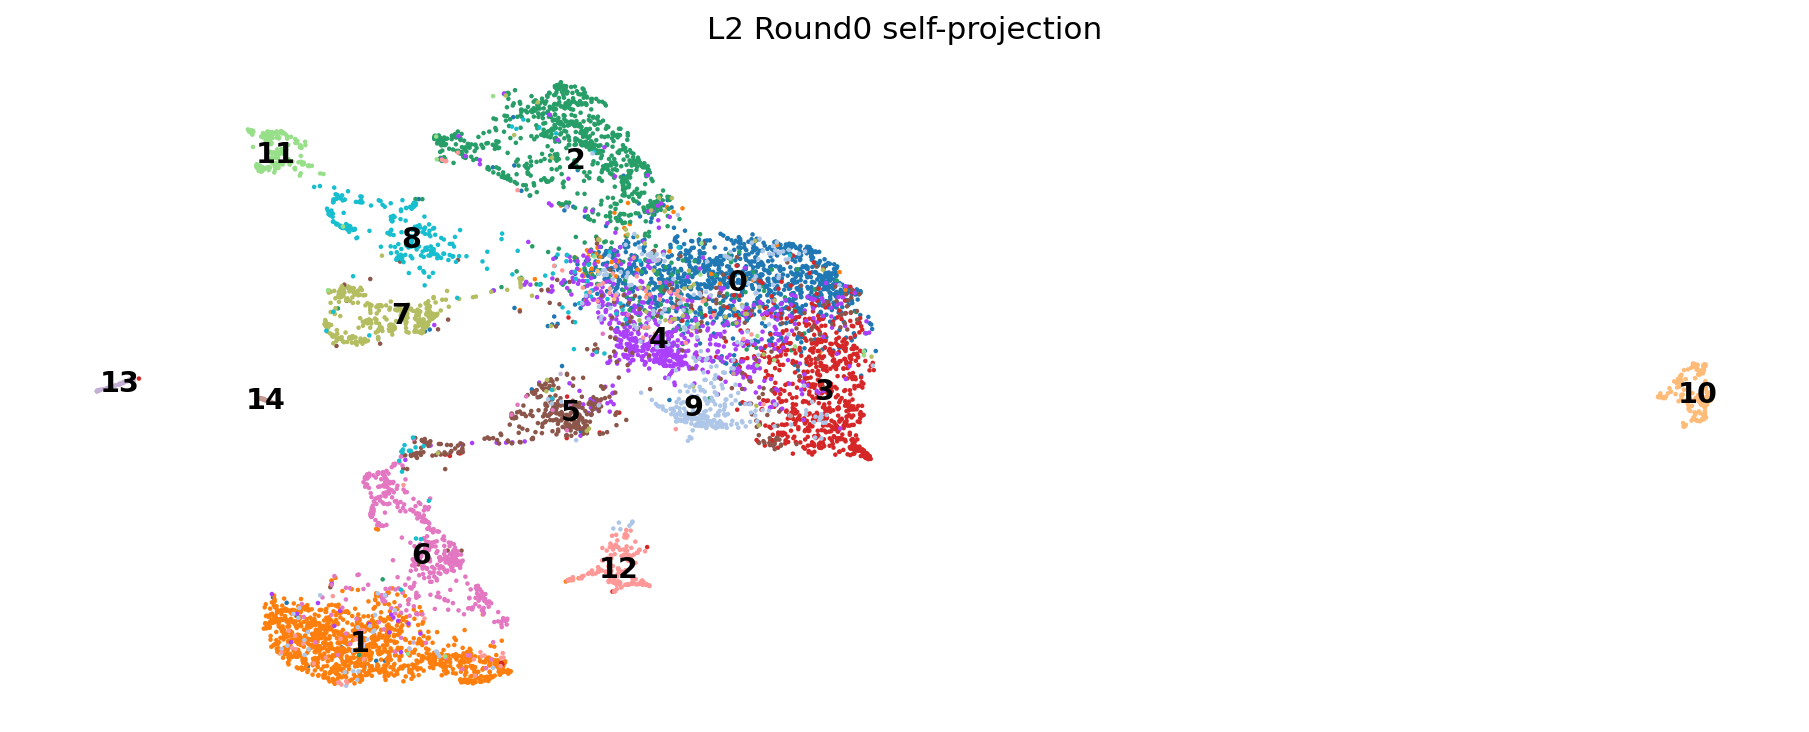

Accuracy on the training set: 0.9331
Accuracy on the hold-out set: 0.7886
Accuracy on the training set: 0.9215
Accuracy on the hold-out set: 0.7913
Max R1mat: 0.601942
Max R2mat: 0.030357
min_acc: 0.782315


<Figure size 960x400 with 0 Axes>

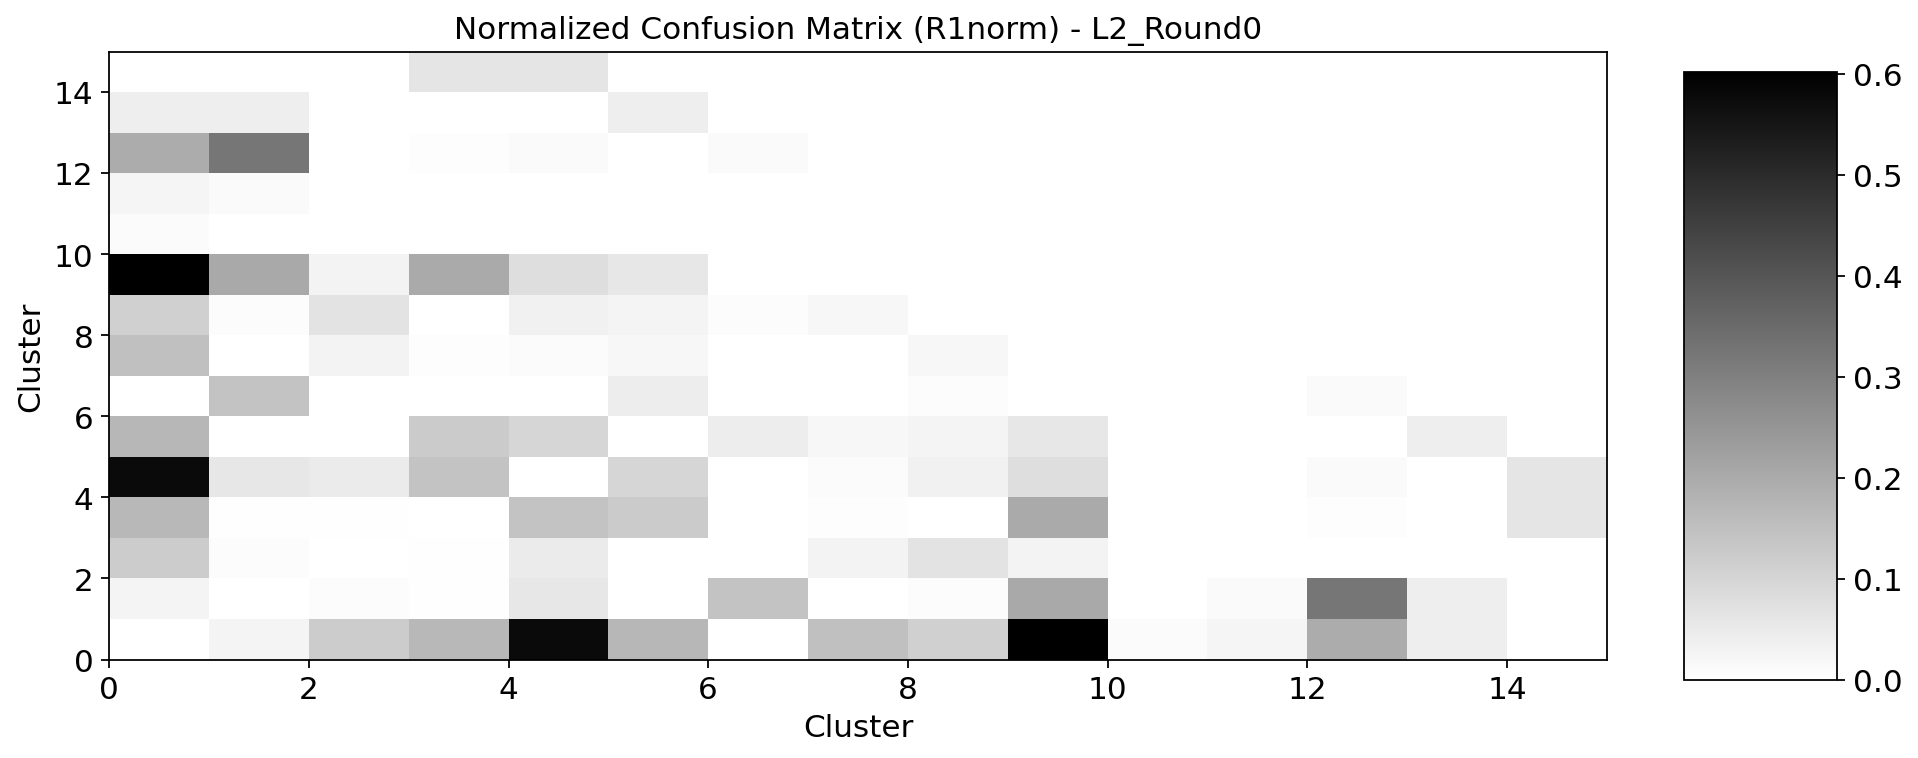

<Figure size 960x400 with 0 Axes>

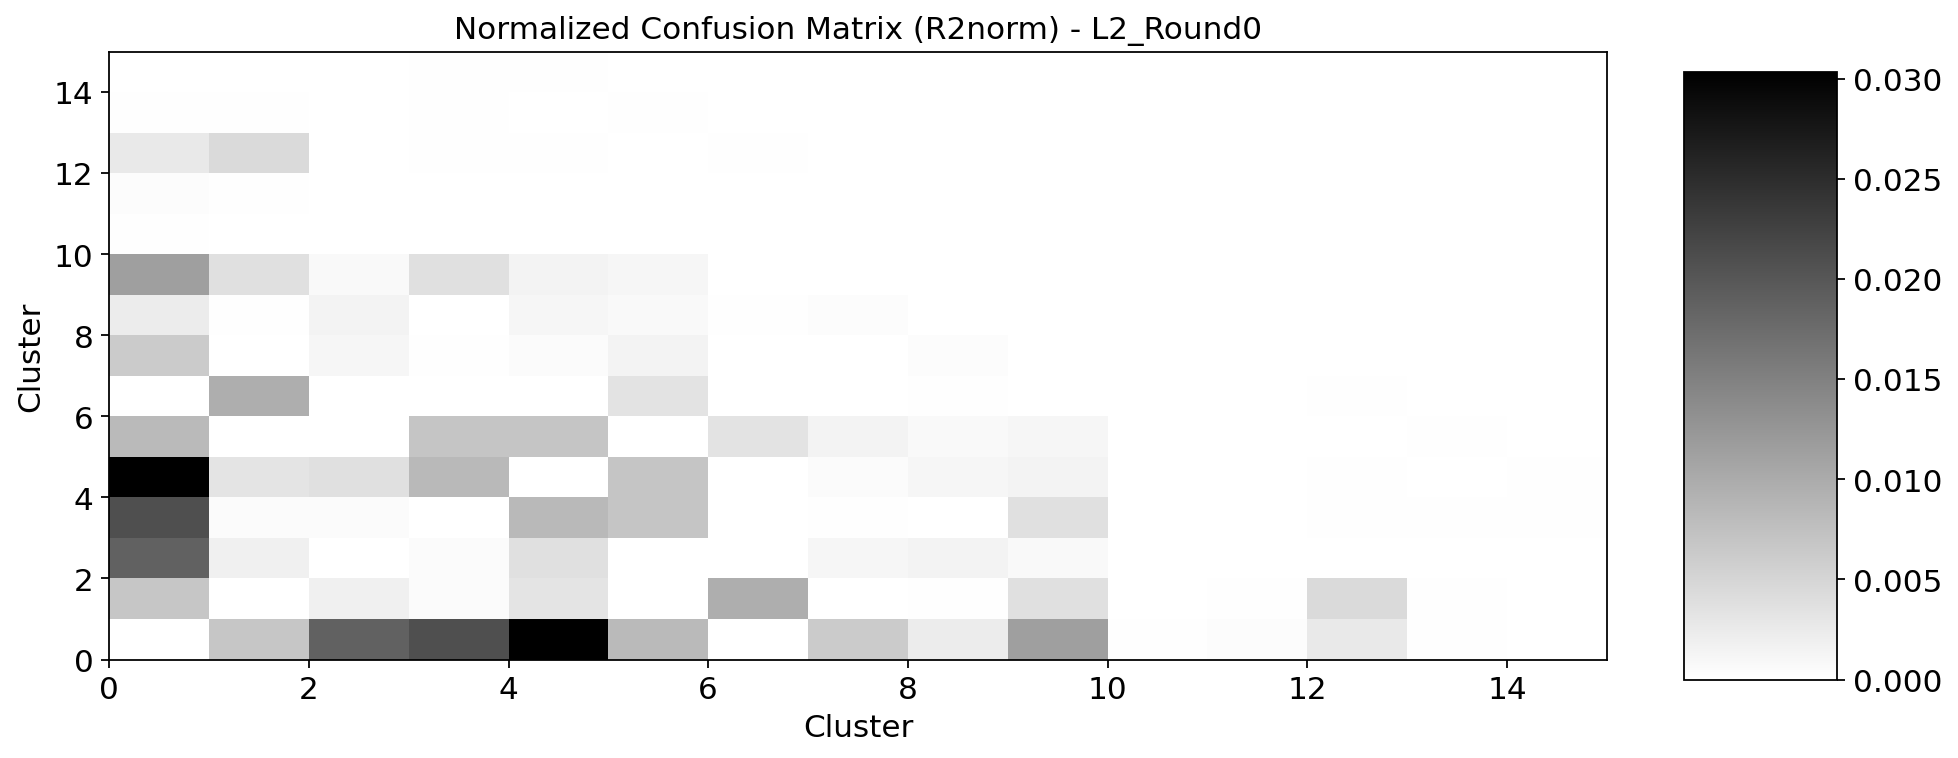

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'L2_Round1' as categorical


IGRAPH U-W- 15 4 --
+ attr: weight (e)
+ edges:
0--4 0--9 0--4 0--9


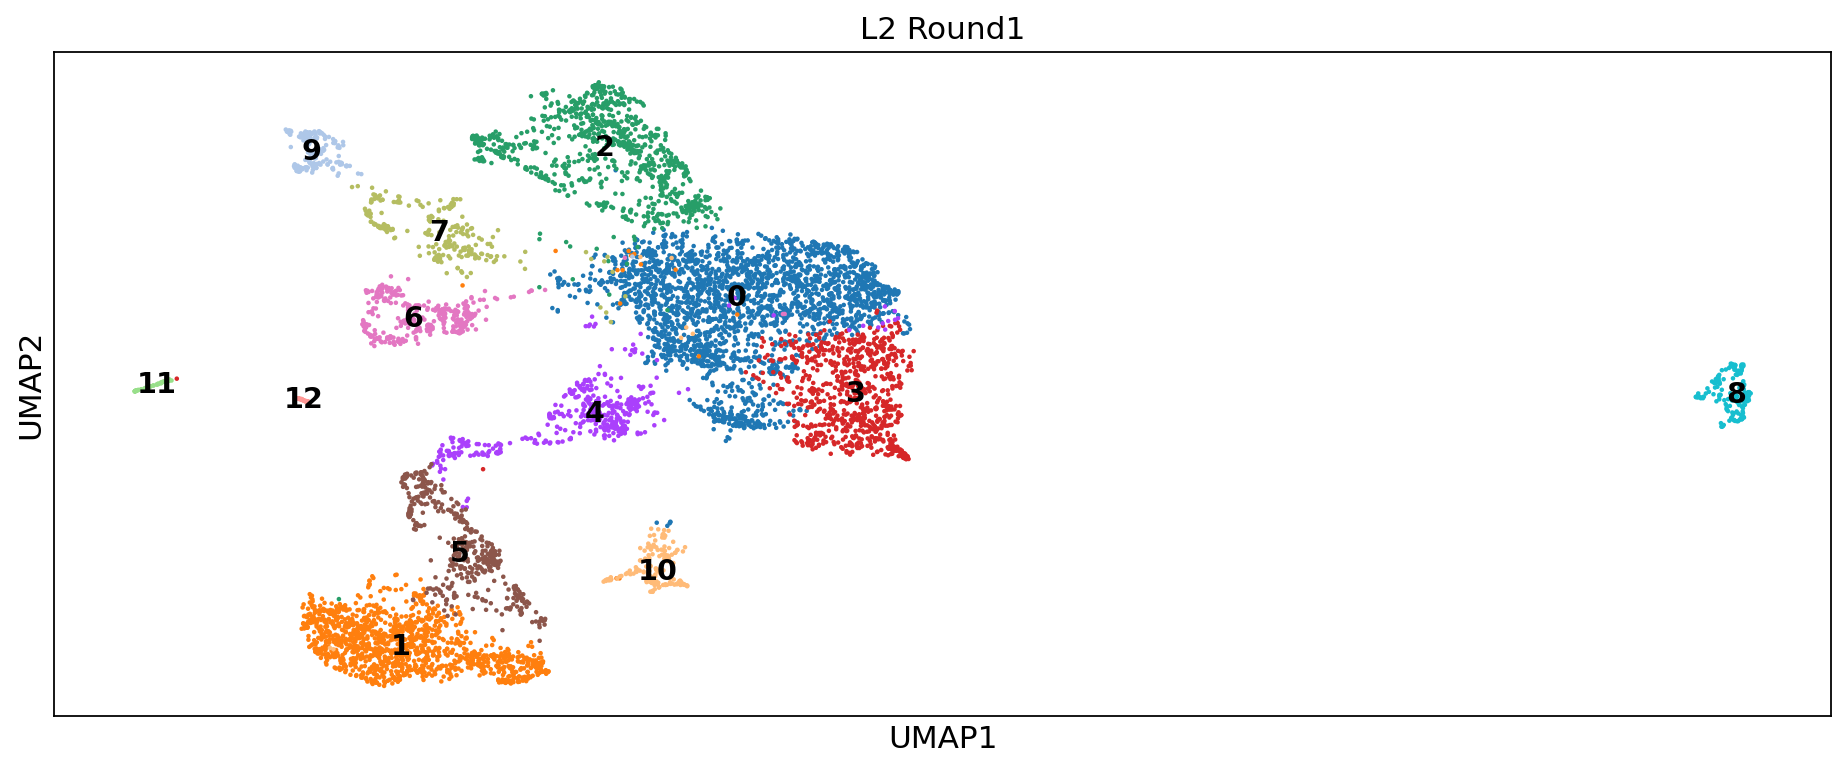

Round2 ...
Mean CV accuracy: 0.8718
Accuracy on the training set: 0.9482
Accuracy on the hold-out set: 0.7713


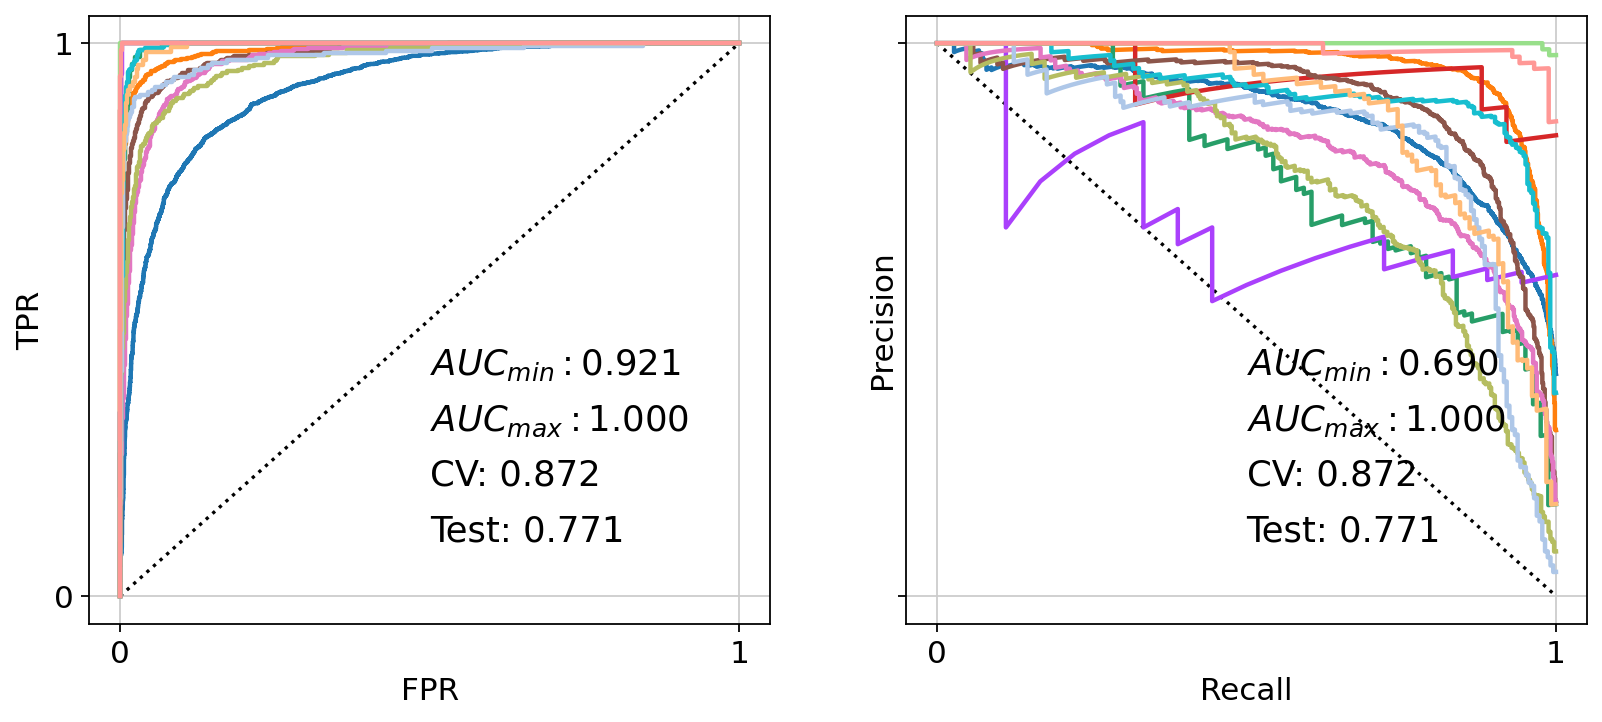

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'L2_Round1_self-projection' as categorical


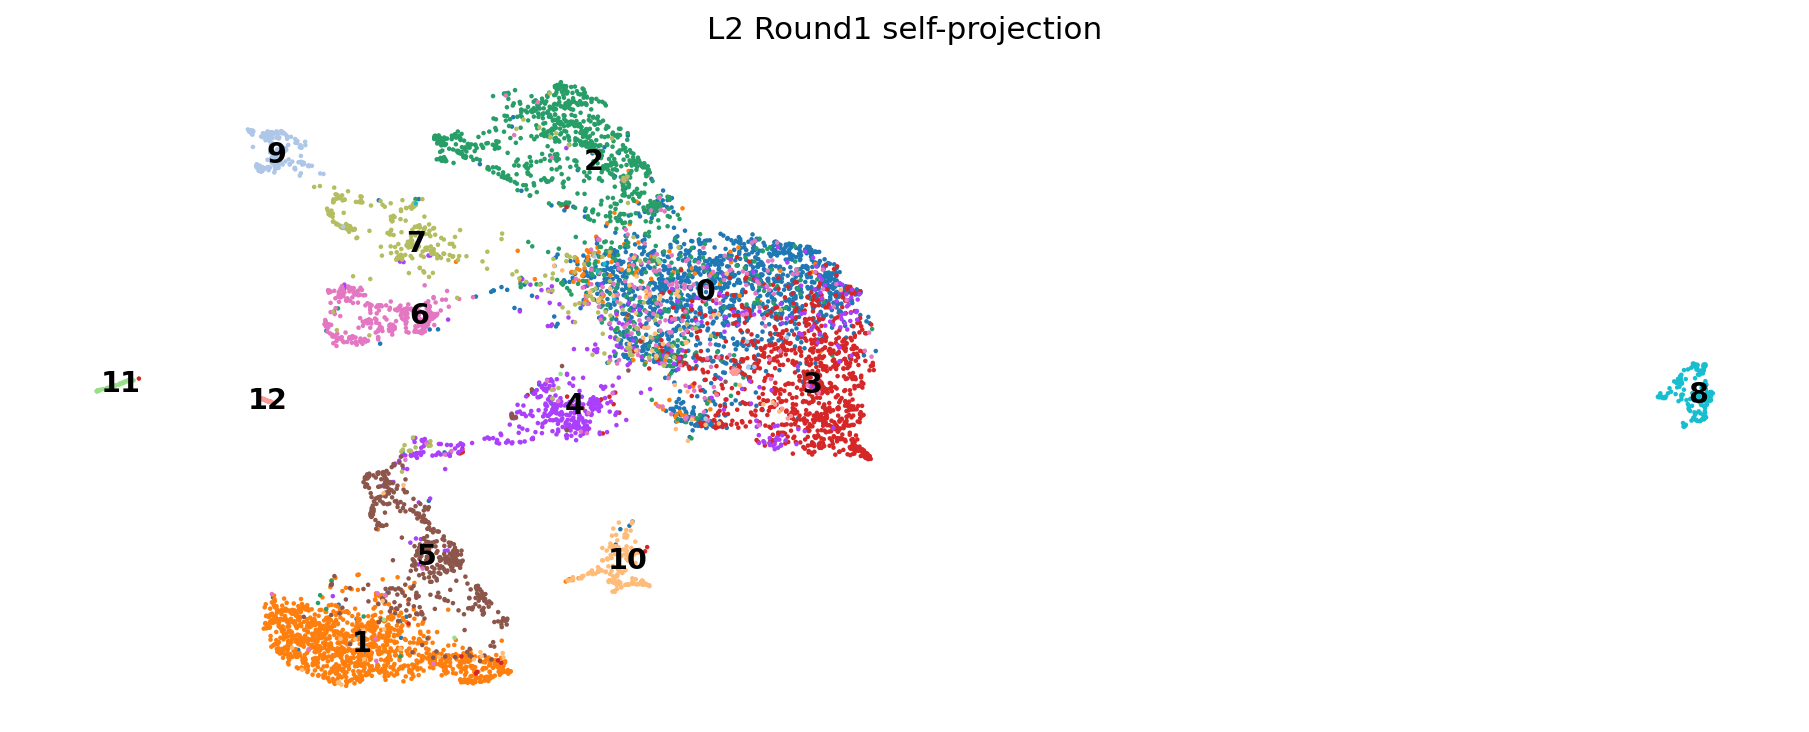

Accuracy on the training set: 0.9409
Accuracy on the hold-out set: 0.7658
Accuracy on the training set: 0.9400
Accuracy on the hold-out set: 0.7671
Max R1mat: 0.577465
Max R2mat: 0.048398
min_acc: 0.765753


<Figure size 960x400 with 0 Axes>

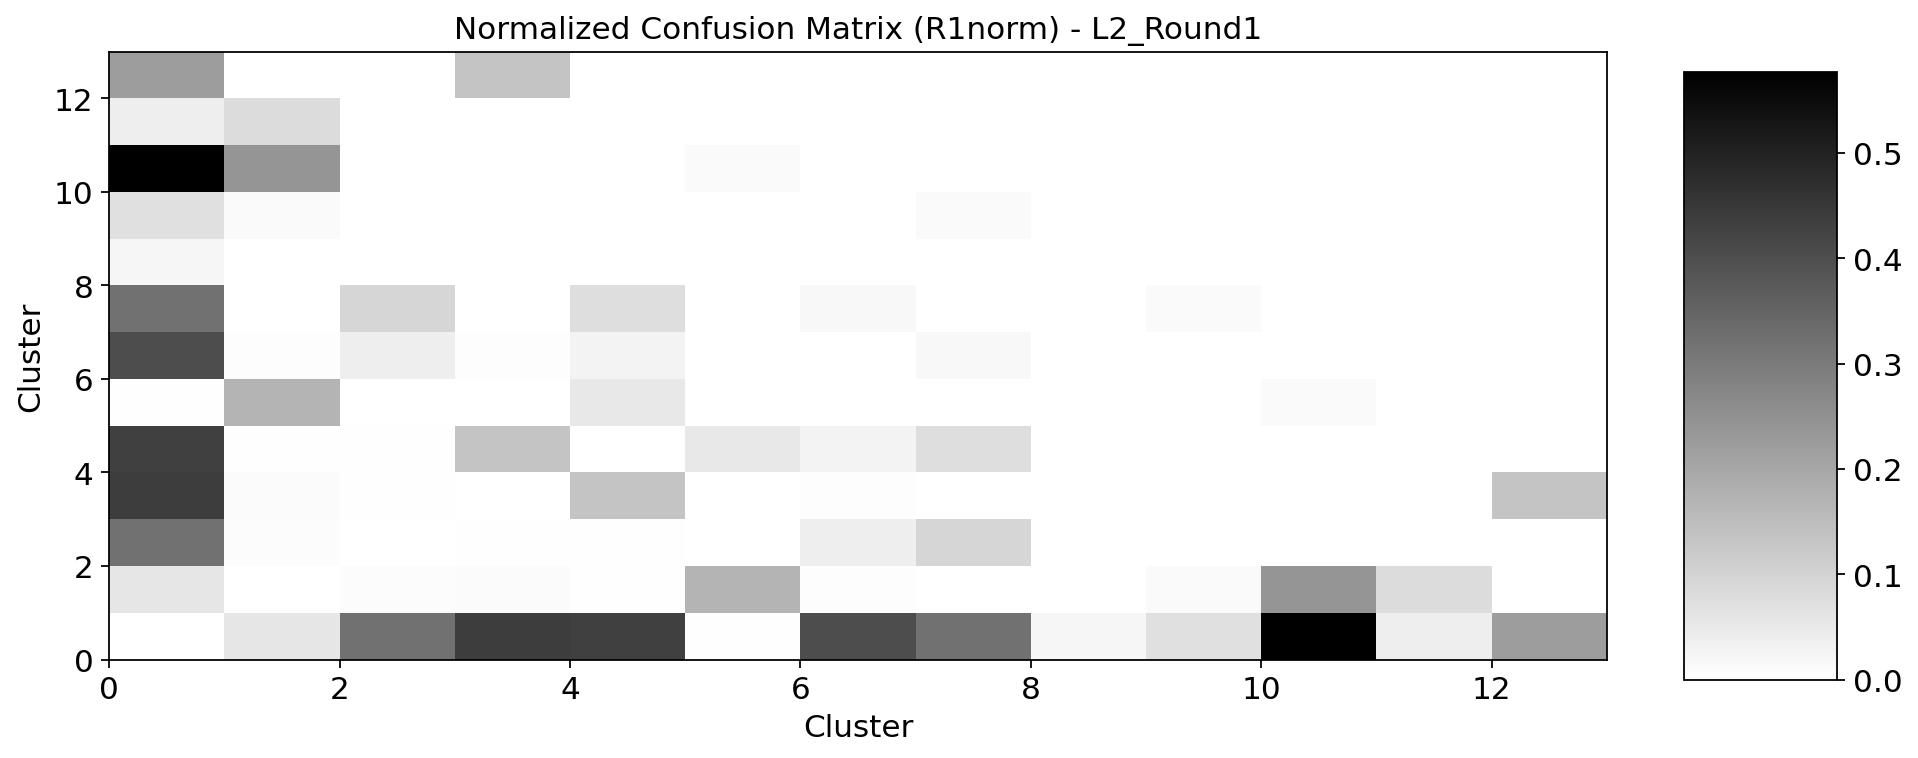

<Figure size 960x400 with 0 Axes>

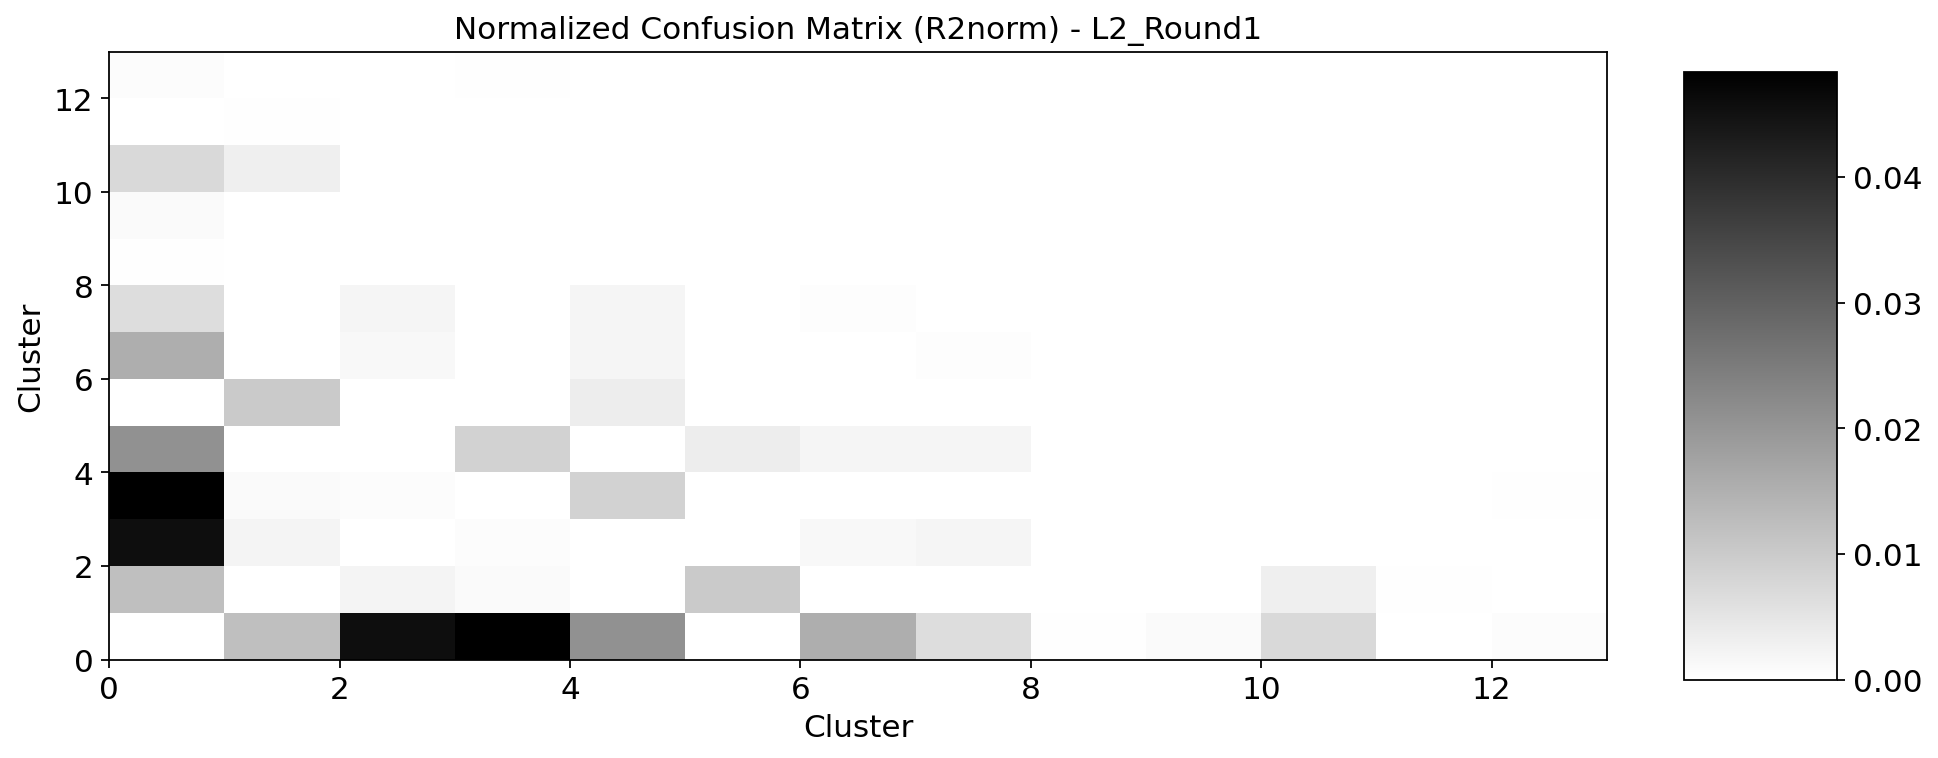

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'L2_Round2' as categorical


IGRAPH U-W- 13 2 --
+ attr: weight (e)
+ edges:
0--10 0--10


IndexError: list index out of range

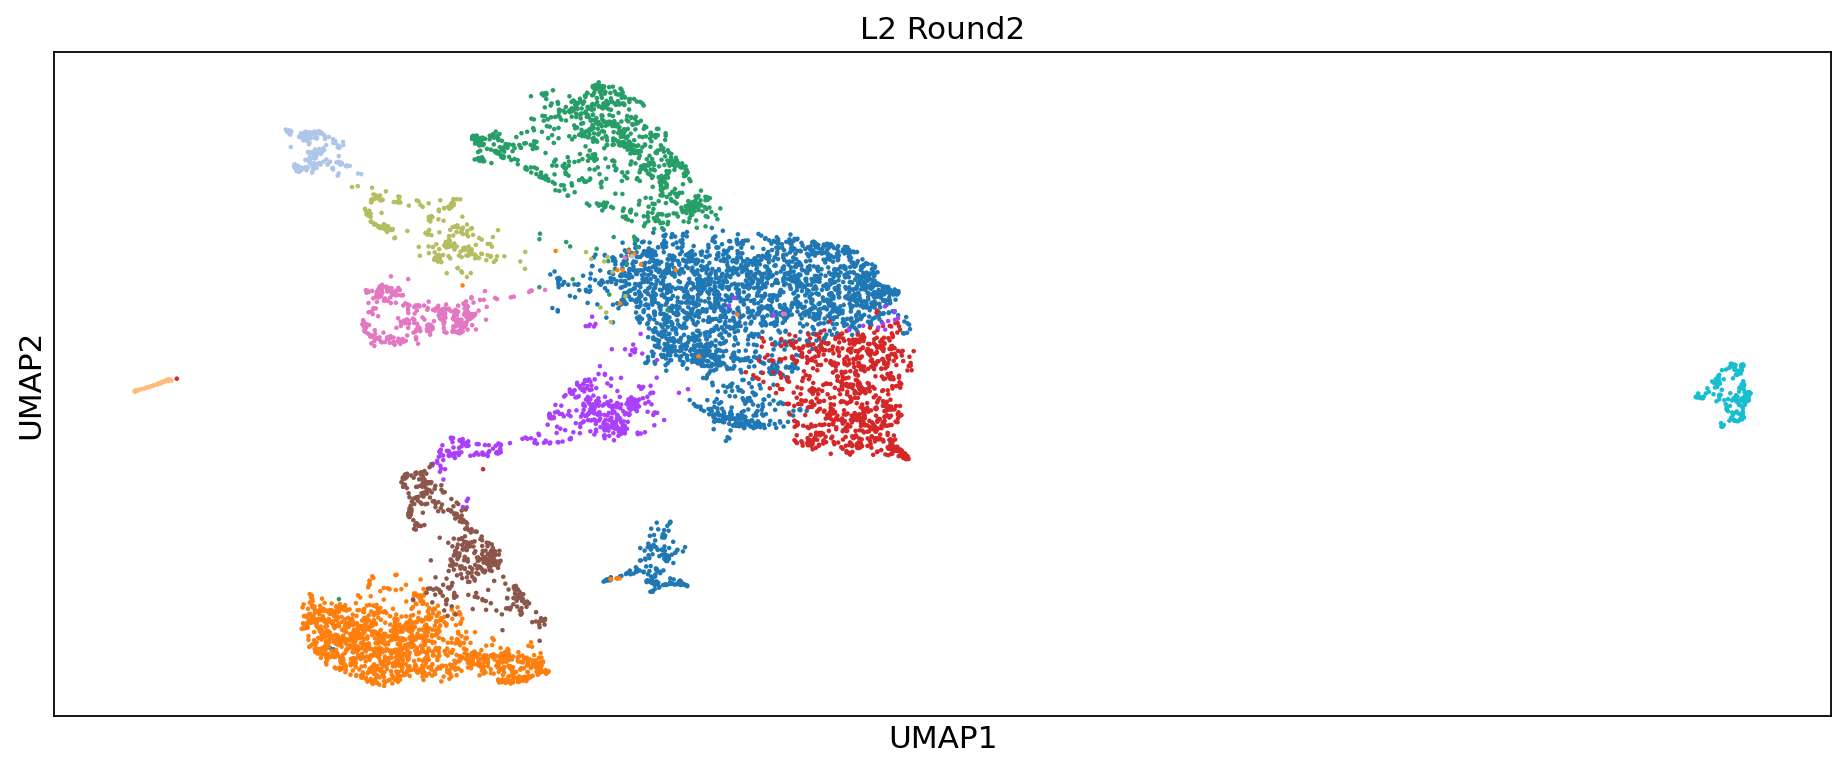

In [174]:
# An initial over-clustering needs to be assigned in consistent with the prefix for the optimization.
# i.e., the optimization prefix is `L2`, the starting point of the optimization of `%s_Round0`%prefix, which is `L2_Round0`.

sc.tl.leiden(adata, resolution=0.6, key_added='L2_Round0')
# i.e., we aim to achieve an accuracy >90% for the whole dataset, optimize based on the PCA space:
SCCAF_optimize_all(ad=adata, plot = True, min_acc=0.85, prefix = 'L2', use='pca')

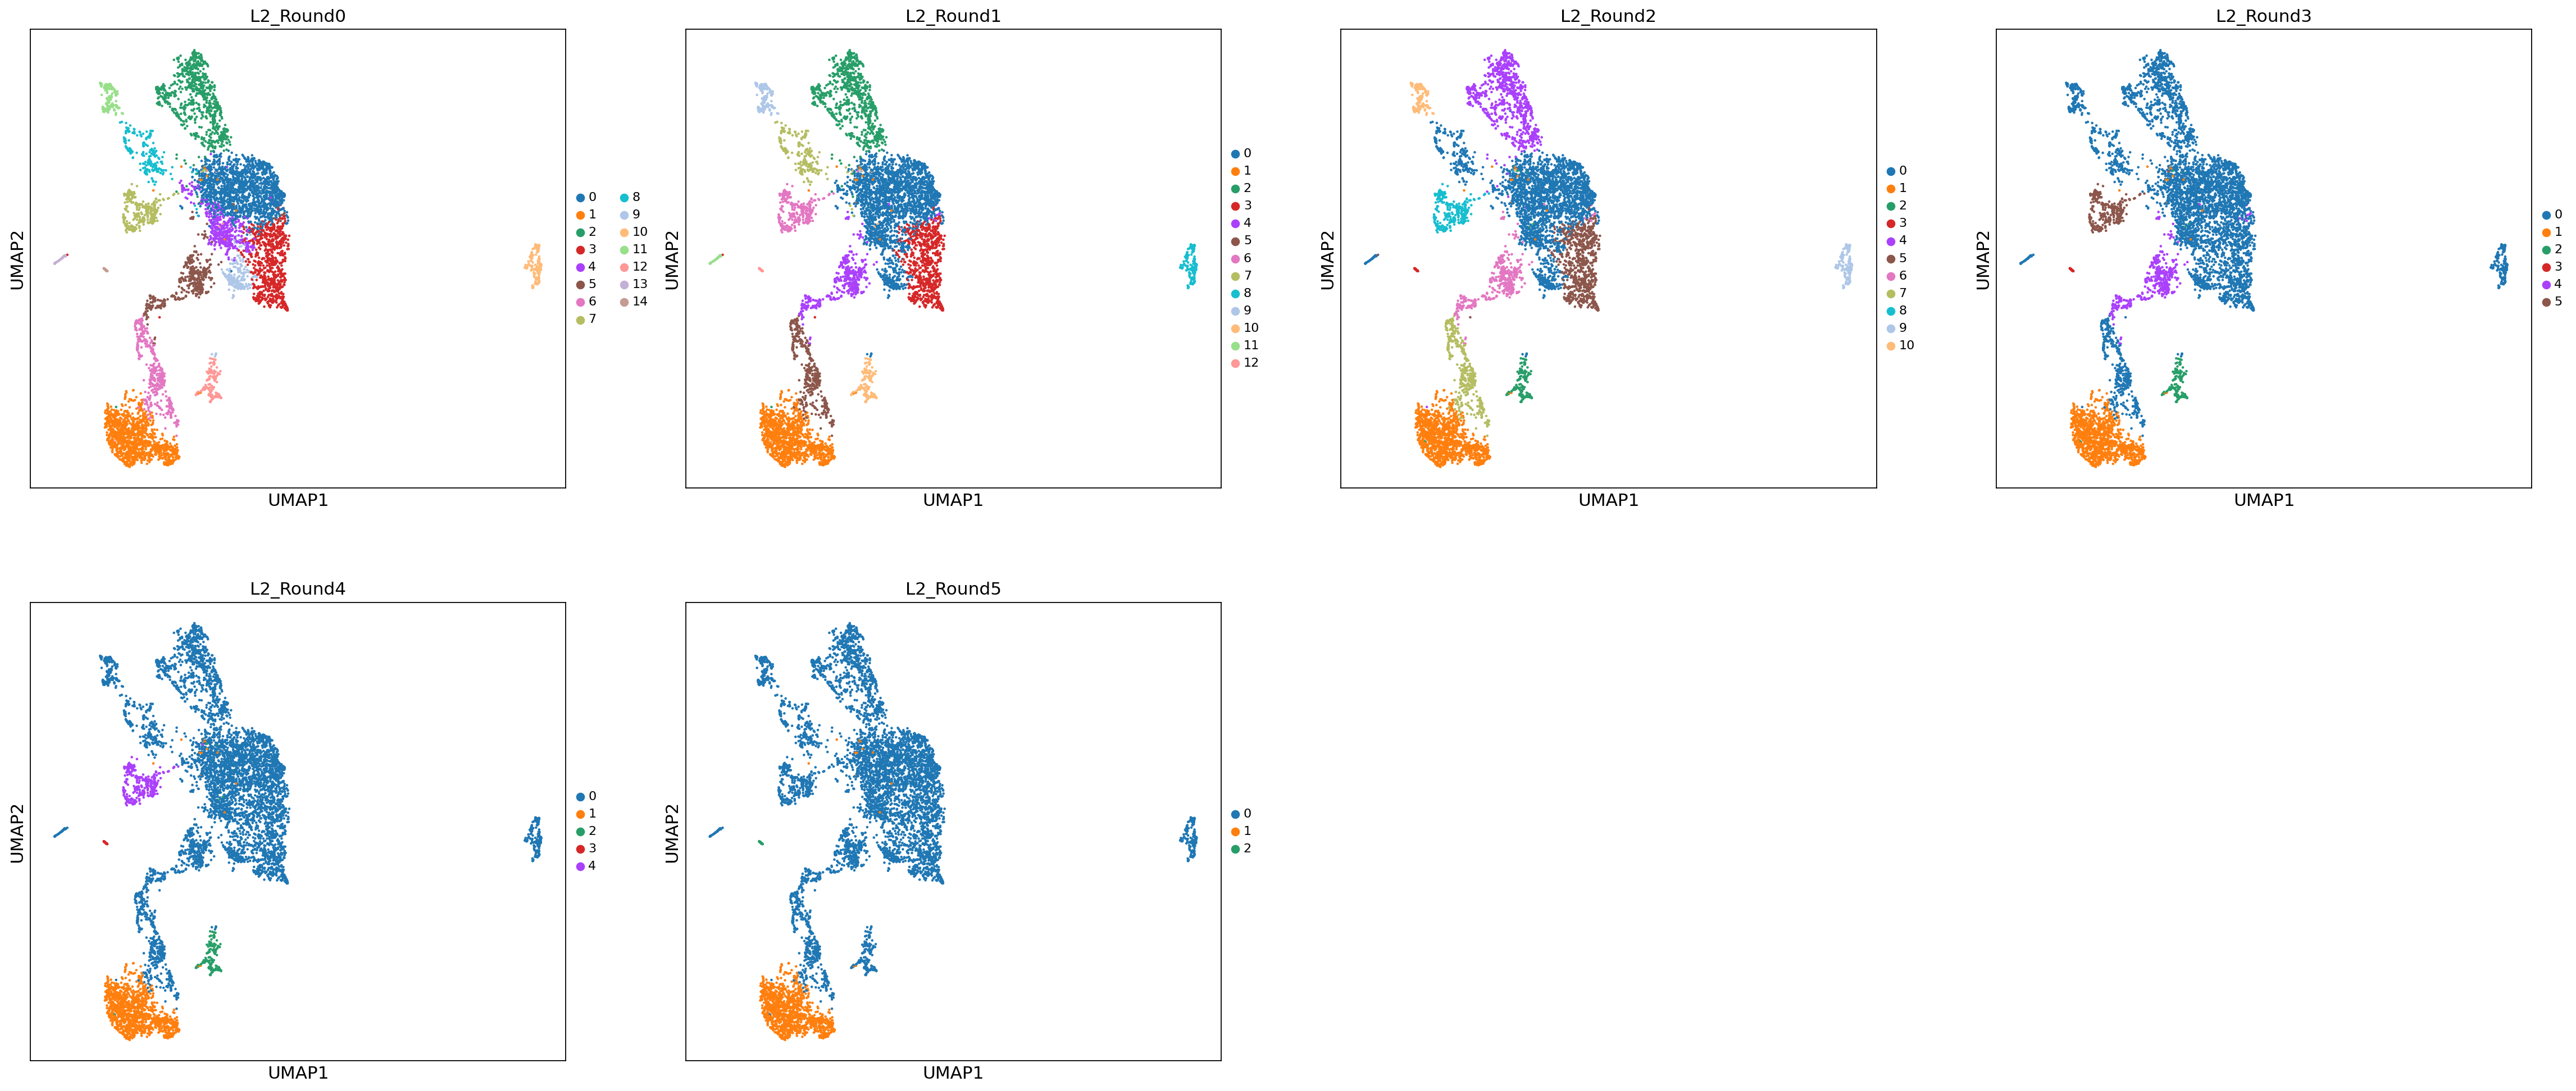

In [132]:
rcParams['figure.figsize'] = 8,7
sc.pl.umap(adata, color=['L2_Round0', 'L2_Round1', 'L2_Round2', 'L2_Round3', 'L2_Round4', 'L2_Round5'], legend_fontsize = 10)

In [ ]:
adata = sc.read('/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/revision/scrna_analysis/PDX_Celltype_scanpy.h5ad')  # the file that will store the analysis results)

In [132]:
# f="/icgc/dkfzlsdf/analysis/B260/projects/przybilm/medulloblastoma/MB_CT_vs_NCT_DESeq2.txt"
# f="/icgc/dkfzlsdf/analysis/B260/projects/przybilm/medulloblastoma/MB_CT_vs_NCT_DESeq2_GROUP.txt"
f="/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/revision/scrna_analysis/MB_CT_vs_NCT_DESeq2_TCC_GROUP_wo_Immune.txt"
pos_df=pd.read_table(f, sep='\t')
pos_df=pos_df.loc[pos_df['log2FoldChange'] > 1,:]
pos_df=pos_df.loc[pos_df['padj'] <= 0.05,:]
neg_df=pd.read_table(f, sep='\t')
neg_df=neg_df.loc[neg_df['log2FoldChange'] < -1,:]
neg_df=neg_df.loc[neg_df['padj'] <= 0.05,:]

In [133]:
gene_list_pos=pos_df['gene_name']
intersect_gene_list_pos=adata.raw.var_names.isin(list(gene_list_pos))
gene_list_pos=adata.raw.var_names[intersect_gene_list_pos]

In [134]:
len(gene_list_pos)

32

In [135]:
gene_list_neg=neg_df['gene_name']
intersect_gene_list_neg=adata.raw.var_names.isin(list(gene_list_neg))
gene_list_neg=adata.raw.var_names[intersect_gene_list_neg]

In [136]:
len(gene_list_neg)

157

In [139]:
sc.tl.score_genes(adata, list(gene_list_pos), ctrl_size=len(gene_list_pos), gene_pool=None, n_bins=25, score_name='Upregulated_Chromothripsis_Score', random_state=0, copy=False, use_raw=True)
sc.tl.score_genes(adata, list(gene_list_neg), ctrl_size=len(gene_list_neg), gene_pool=None, n_bins=25, score_name='Downregulated_Chromothripsis_Score', random_state=0, copy=False, use_raw=True)

computing score 'Upregulated_Chromothripsis_Score'
    finished: added
    'Upregulated_Chromothripsis_Score', score of gene set (adata.obs).
    478 total control genes are used. (0:00:01)
computing score 'Downregulated_Chromothripsis_Score'
    finished: added
    'Downregulated_Chromothripsis_Score', score of gene set (adata.obs).
    3583 total control genes are used. (0:00:01)


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


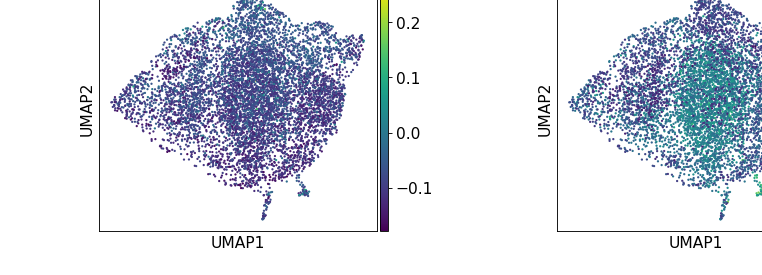

In [140]:
sc.pl.umap(adata, color=['Upregulated_Chromothripsis_Score', 'Downregulated_Chromothripsis_Score'], sort_order = False, save = '_PDX_merge_chromothripsisScore_TCC_GROUP_wo_Immune.pdf', wspace = 0.5)

In [ ]:
# assign the column with the cell_type id in the metadata of the annData object
metadata = pd.DataFrame(adata.obs, index=adata.obs_names)
# metadata.to_csv('/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/revision/scrna_analysis/scanpy/Nuclei_projection_Riemondy_metadata.csv')
metadata.to_csv('/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/revision/scrna_analysis/scanpy/PDX_CT_scoring_bulk.csv')